# Projeto: *Music Generation*
* Geração da próxima nota musical.
* Neste exemplo, utilizaremos alguns dos *Chorais de Bach* para gerar músicas. Os chorais são uma parte importante da música sacra de Bach e são frequentemente encontrados em suas obras corais, como as cantatas, os oratórios e a Paixão de São Mateus. Os chorais de Bach são caracterizados por suas melodias ricas e harmonias sofisticadas, e muitos deles se tornaram amplamente conhecidos e apreciados até hoje.

Para essa aplicação, utilizaremos um [conjunto de dados](https://drive.google.com/drive/folders/1dKOdOhmcijZhoZEYwDJ-to3O4jAfiiD_?usp=sharing) contendo alguns dos Corais de Bach.

Este conjunto é composto por 382 corais.

Cada coral tem entre 100 e 640 passos de tempo e cada passo de tempo contém 4 inteiros, onde cada inteiro corresponde ao índice de uma nota em um piano (exceto pelo valor 0, que significa que nenhuma nota é tocada).

Treine um modelo - recorrente, convolucional ou ambos - que possa prever o próximo passo de tempo (quatro notas), dado uma sequência de passos de tempo de um coral.

Em seguida, use esse modelo para gerar música semelhante a Bach, uma nota de cada vez: você pode fazer isso fornecendo ao modelo o início de um coral e pedindo para ele prever o próximo passo de tempo, em seguida, acrescentando esses passos de tempo à sequência de entrada e pedindo ao modelo pela próxima nota, e assim por diante.

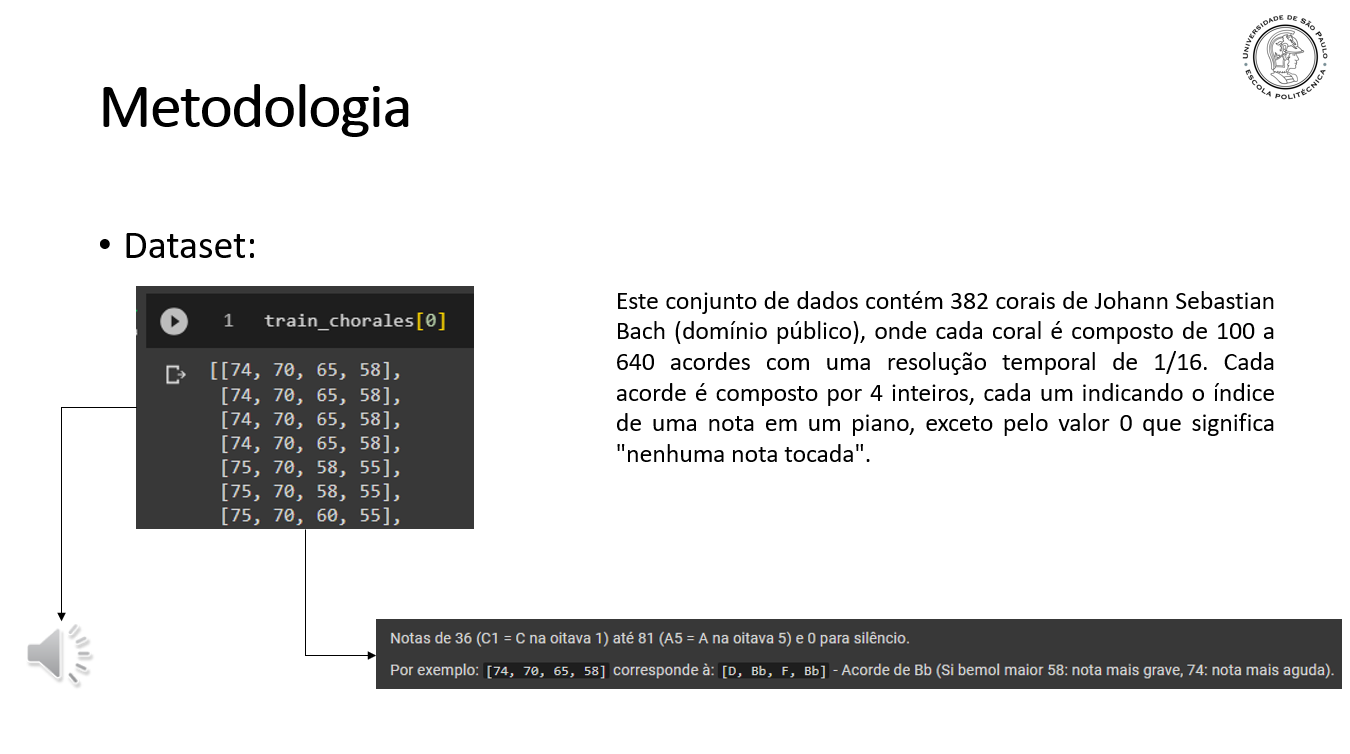

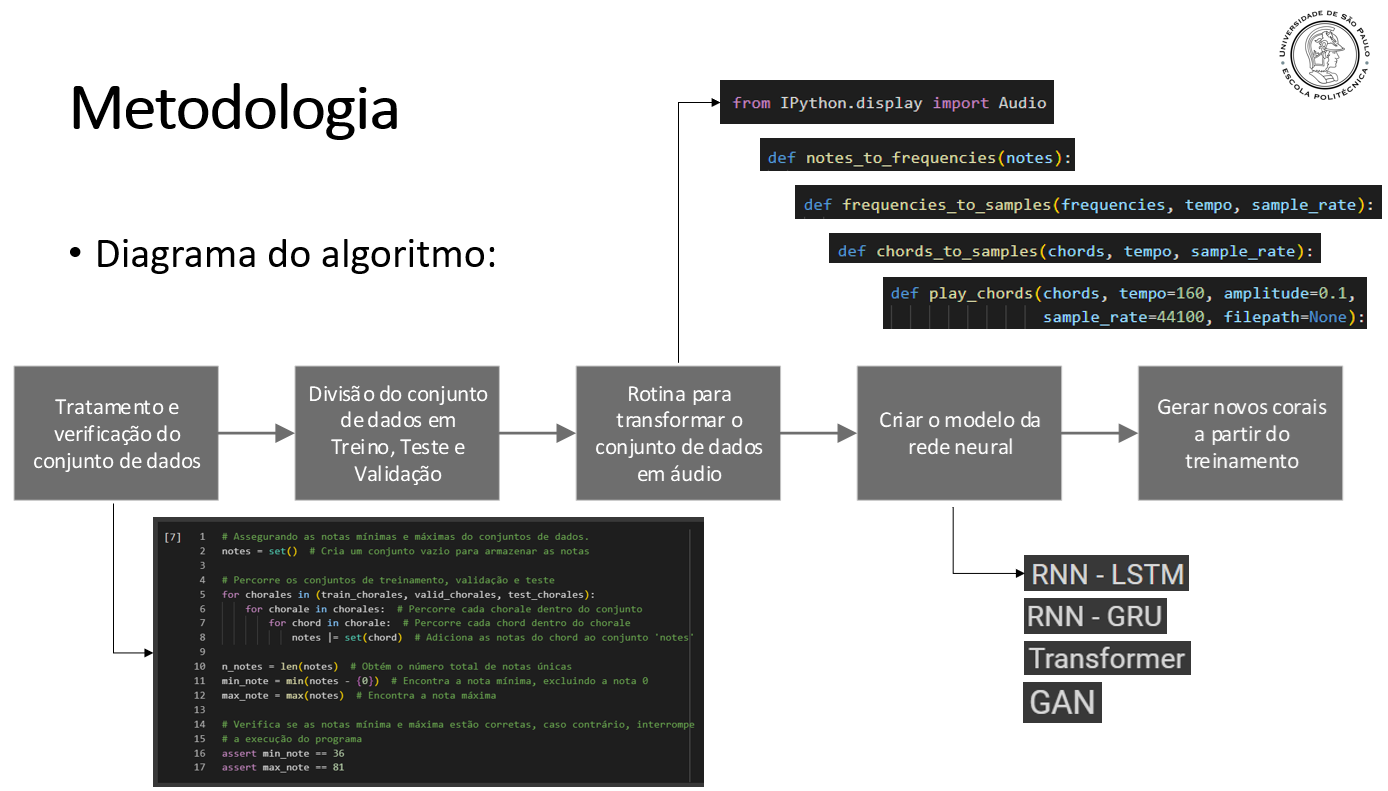

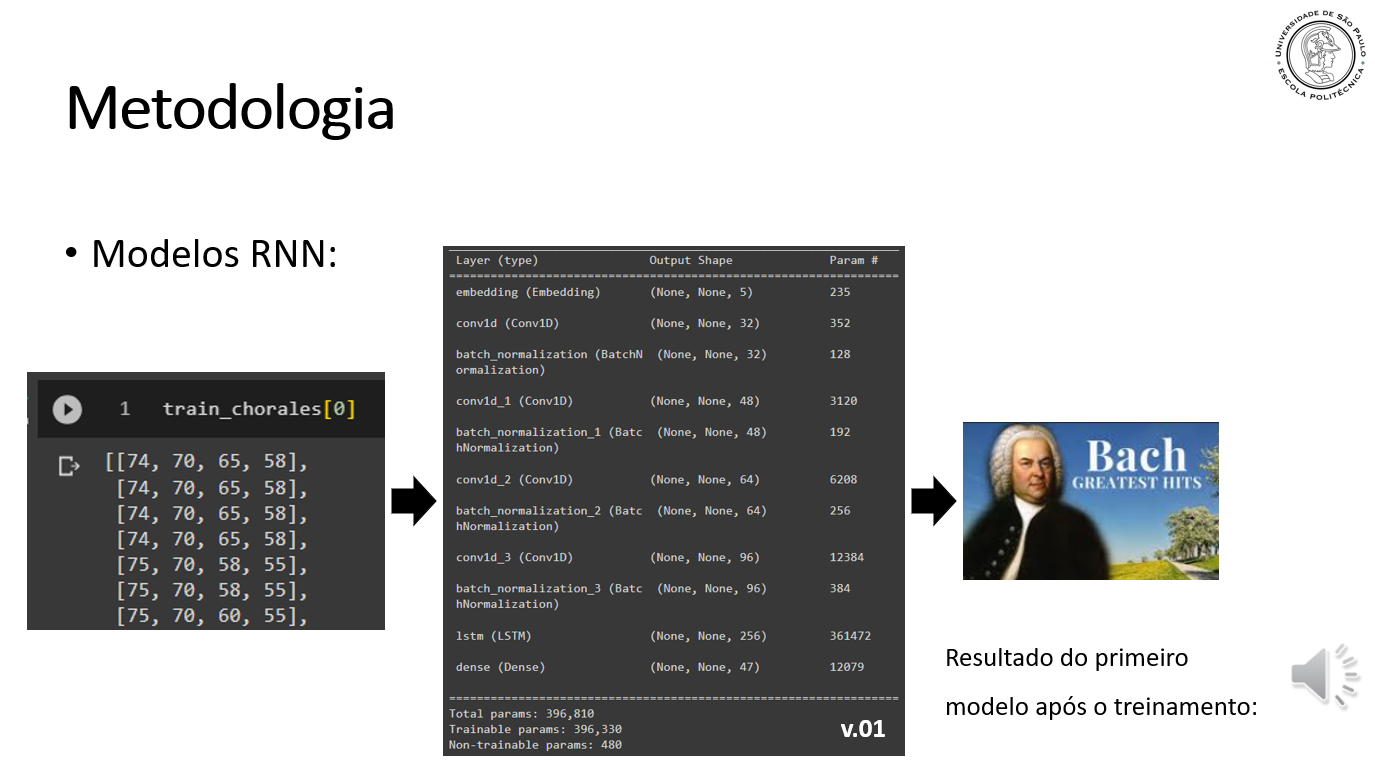

# Setup Python

In [ ]:
# Imports comuns
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import keras

# Python ≥3.5 - requerido
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Estabilizar e padronizar as respostas deste notebook.
np.random.seed(42)
tf.random.set_seed(42)

import random
random.seed(42)

# Para confgurar a não exibição de mensagens durante a compilação verbose=0
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

Principais funções

In [ ]:
%%capture

!gdown 1koaH1DFM_FqUCBAj126TYvpig5DdMUep

In [ ]:
from music_gen_functions import *

Endereços para salvar as músicas e modelos

In [ ]:
MUSIC_FILES_PATH = '/content/drive/MyDrive/Colab Notebooks/_phd/[2023 - PSI5123]/_musicfiles'

In [ ]:
MODELS_PATH = '/content/drive/MyDrive/Colab Notebooks/_phd/[2023 - PSI5123]/_models'

In [ ]:
COMPASS = 60

# Download do dataset contendo os chorais de Bach

In [ ]:
file_path = download_chorales_file()
print(file_path)

/root/.keras/datasets/jsb_chorales/jsb_chorales.tgz


In [ ]:
# Obtém o diretório pai do caminho de arquivo especificado
jsb_chorales_dir = Path(file_path).parent

# Encontra todos os arquivos que correspondem ao padrão "train/chorale_*.csv" no diretório
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))

# Encontra todos os arquivos que correspondem ao padrão "valid/chorale_*.csv" no diretório
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))

# Encontra todos os arquivos que correspondem ao padrão "test/chorale_*.csv" no diretório
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [ ]:
print(train_files)

[PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_000.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_001.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_002.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_003.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_004.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_005.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_006.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_007.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_008.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_009.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_010.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_011.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_012.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_013.csv'), Posix

In [ ]:
# Carrega os dados dos arquivos de treinamento usando a função load_chorales
train_chorales = load_chorales(train_files)

# Carrega os dados dos arquivos de validação usando a função load_chorales
valid_chorales = load_chorales(valid_files)

# Carrega os dados dos arquivos de teste usando a função load_chorales
test_chorales = load_chorales(test_files)

In [ ]:
train_chorales[0]

[[74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [75, 70, 58, 55],
 [75, 70, 58, 55],
 [75, 70, 60, 55],
 [75, 70, 60, 55],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 70, 62, 55],
 [77, 70, 62, 55],
 [77, 69, 62, 55],
 [77, 69, 62, 55],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [77, 65, 62, 50],
 [77, 65, 62, 50],
 [77, 65, 60, 50],
 [77, 65, 60, 50],
 [74, 67, 58, 55],
 [74, 67, 58, 55],
 [74, 67, 58, 53],
 [74, 67, 58, 53],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 65, 57

Notas de 36 (C1 = C na oitava 1) até 81 (A5 = A na oitava 5) e 0 para
silêncio.

Por exemplo: `[74, 70, 65, 58]` corresponde à: `[D, Bb, F, Bb]` - Acorde de Bb (Si bemol maior 58: nota mais grave, 74: nota mais aguda).

In [ ]:
min_note, max_note, n_notes = get_min_max_notes(train_chorales, valid_chorales, test_chorales)
print(f"Nota mínima: {min_note}, Nota máxima: {max_note}, Total notas únicas: {n_notes}")

Nota mínima: 36, Nota máxima: 81, Total notas únicas: 47


# Ouvindo o Dataset

Vamos escrever algumas funções para ouvir esses chorais escrevendo um sintetizador para traduzir o dataset em audio.

In [ ]:
from IPython.display import Audio

In [ ]:
def notes_to_frequencies(notes):
    # A frequência dobra ao subir uma oitava; existem 12 semitons em cada oitava;
    # A nota A na oitava 3 é 440 Hz, e ela corresponde ao número 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

Esse código define a função `notes_to_frequencies` que converte números de notas musicais em suas respectivas frequências em hertz.

A função recebe como entrada um array ou lista de números de notas, onde cada número representa uma nota musical. O código então realiza o seguinte cálculo para converter cada número de nota em sua frequência correspondente:

* Subtrai 69 de cada número de nota para normalizar a escala. Isso é feito porque o número 69 corresponde à nota A na oitava 3, que possui uma frequência de 440 Hz.

* Divide o resultado anterior por 12 para obter a diferença em semitons em relação à nota A na oitava 3.

* Calcula 2 elevado ao valor obtido no passo anterior. Isso é feito porque a frequência dobra a cada oitava (que tem 12 semitons) ao subir uma oitava.

* Multiplica o resultado do passo anterior por 440, que é a frequência da nota A na oitava 3.

O resultado final é um array ou lista com as frequências correspondentes às notas musicais fornecidas. Essas frequências indicam a quantidade de oscilações por segundo para cada nota, e são usadas para gerar sons musicais com as notas específicas.

In [ ]:
def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo  # o tempo é medido em batidas por minuto
    # Para reduzir o som de clique a cada batida, arredondamos as frequências para tentar
    # obter as amostras próximas de zero no final de cada nota.
    frequencies = np.round(note_duration * frequencies) / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removendo todas as notas com frequências ≤ 9 Hz (inclui a nota 0 = silêncio)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

Esse código define a função `frequencies_to_samples` que converte frequências em amostras de áudio.

A função recebe três argumentos:

* `frequencies`: uma lista ou array contendo as frequências das notas musicais.
* `tempo`: o tempo em batidas por minuto.
* `sample_rate`: a taxa de amostragem, ou seja, o número de amostras de áudio por segundo.
O código realiza as seguintes etapas para converter as frequências em amostras de áudio:

* Calcula a duração de uma nota, dividindo 60 pelo tempo em batidas por minuto. Isso fornece a duração de cada nota em segundos.

* Arredonda as frequências multiplicadas pela duração da nota para tentar obter amostras próximas de zero no final de cada nota. Isso é feito para reduzir o som de clique que pode ocorrer quando há uma mudança abrupta de frequência entre as notas.

* Calcula o número de amostras necessário para representar a duração da nota, multiplicando a duração da nota pelo sample_rate.

* Cria um array chamado time que representa o tempo para cada amostra de áudio. Esse array é criado usando `np.linspace` para gerar valores igualmente espaçados de 0 a duração da nota.

* Calcula formas de onda senoidais (`sine_waves`) multiplicando as frequências pelas amostras de tempo e pelas constantes relacionadas a 2π. Isso cria uma forma de onda para cada frequência.

* Multiplica as formas de onda senoidais pelo resultado da comparação entre as frequências e 9. Essa comparação cria um array booleano indicando quais frequências são maiores que 9 Hz. Isso é feito para remover as notas com frequências muito baixas, incluindo a nota 0, que representa o silêncio.

* Retorna as formas de onda senoidais resultantes como um array unidimensional.

Em resumo, essa função gera amostras de áudio a partir das frequências das notas musicais. As amostras representam formas de onda senoidais para cada nota, com ajustes para evitar cliques e remover notas de frequência muito baixa. Essas amostras podem ser usadas para reproduzir as notas musicais com as frequências correspondentes.

In [ ]:
def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]]  # faz a última nota um pouco mais longa
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo  # fade out na última nota
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

Esse código define a função `chords_to_samples` que converte acordes musicais em amostras de áudio.

A função recebe três argumentos:

* `chords`: uma lista ou array contendo os acordes musicais representados como números de notas.
* `tempo`: o tempo em batidas por minuto.
* `sample_rate`: a taxa de amostragem, ou seja, o número de amostras de áudio por segundo.
O código realiza as seguintes etapas para converter os acordes em amostras de áudio:

* Chama a função `notes_to_frequencies` para converter os números de notas dos acordes em suas respectivas frequências.

* Adiciona a última frequência duplicada na lista de frequências. Isso faz com que a última nota do acorde seja um pouco mais longa em relação às outras.

* Usa uma compreensão de lista para chamar a função `frequencies_to_samples` para cada melodia (conjunto de frequências) na transposta das frequências. A função `frequencies_to_samples` gera amostras de áudio para cada melodia com base no tempo e taxa de amostragem fornecidos.

* Calcula a duração do fade-out na última nota, multiplicando a taxa de amostragem pelo número de segundos em um minuto dividido pelo tempo. Isso determina quantas amostras serão usadas para criar o fade-out.

* Cria um array chamado `fade_out` que contém uma sequência de valores de intensidade decrescentes, variando de 1 a 0. Esses valores são usados para aplicar um efeito de fade-out na última nota.

* Multiplica as amostras da última nota pelo array `fade_out`, fazendo com que a intensidade das amostras diminua gradualmente.

* Calcula a média das amostras de áudio de todas as melodias dos acordes usando `np.mean` ao longo do eixo 0. Isso cria um único conjunto de amostras de áudio que representa todos os acordes.

* Retorna as amostras de áudio resultantes como um array unificado.

Em resumo, essa função converte acordes musicais em amostras de áudio que podem ser reproduzidas para ouvir os acordes em forma de som.

In [ ]:
def play_chords(chords, tempo=160, amplitude=0.1,
                sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

Esse código define a função `play_chords` que reproduz acordes musicais.

A função recebe vários argumentos opcionais:

* `chords`: uma lista ou array contendo os acordes musicais representados como números de notas.
* `tempo`: o tempo em batidas por minuto (padrão: 160).
* `amplitude`: a amplitude do som dos acordes (padrão: 0.1).
* `sample_rate`: a taxa de amostragem, ou seja, o número de amostras de áudio por segundo (padrão: 44100).
* `filepath`: o caminho do arquivo WAV para salvar o áudio (opcional).
O código realiza as seguintes etapas:

* Chama a função `chords_to_samples` para converter os acordes em amostras de áudio, com base nos parâmetros fornecidos (tempo, taxa de amostragem).

* Multiplica as amostras de áudio pelo valor da amplitude para controlar o volume do som dos acordes.

* Se um caminho de arquivo (`filepath`) for fornecido, o código salva as amostras de áudio em um arquivo WAV usando a biblioteca `scipy.io.wavfile`.

* Se um caminho de arquivo foi fornecido, a função retorna `display(Audio(filepath))`, que exibe um player de áudio no ambiente em que o código está sendo executado, permitindo a reprodução do áudio a partir do arquivo.

* Se nenhum caminho de arquivo foi fornecido, a função retorna `display(Audio(samples, rate=sample_rate))`, que exibe um player de áudio com base nas amostras de áudio geradas, permitindo a reprodução direta do áudio.

Em resumo, essa função reproduz acordes musicais, convertendo-os em amostras de áudio e permitindo a reprodução do áudio gerado. O áudio pode ser reproduzido diretamente ou salvo em um arquivo WAV, dependendo dos parâmetros fornecidos.

Portanto, em linhas gerais, nessas funções temos as funções fornecem utilidades relacionadas à geração e reprodução de notas e acordes musicais. Cada função possui um comentário explicando sua finalidade.

* A função `notes_to_frequencies` converte números de notas em suas respectivas frequências em hertz.

* A função `frequencies_to_samples` gera formas de onda senoidais com base nas frequências, duração das notas e taxa de amostragem especificadas.

* A função `chords_to_samples` mescla várias melodias de acordes em uma única amostra de áudio.

* A função `play_chords` reproduz os acordes gerados, podendo salvar o áudio em um arquivo WAV se o caminho do arquivo for fornecido.

Lembrando que esse código faz uso de bibliotecas como `numpy`, `IPython.display` e `scipy.io` para manipulação de áudio e cálculos musicais.

In [ ]:
for index in range(2):
    play_chords(train_chorales[index])

Output hidden; open in https://colab.research.google.com to view.

Salvando exemplo para apresentação:

In [ ]:
play_chords(train_chorales[0], filepath=f"{MUSIC_FILES_PATH}/train_chorales_0.wav")

Output hidden; open in https://colab.research.google.com to view.

A fim de ser capaz de gerar novos chorais, queremos treinar um modelo que possa prever o próximo acorde dado todos os acordes anteriores. Se tentarmos ingenuamente prever o próximo acorde de uma vez, prevendo todas as 4 notas de uma só vez, corremos o risco de obter notas que não combinam muito bem juntas (a não ser que você seja um conhecedor e especialista em harmonia musical!).
Assim, é muito melhor e mais simples prever uma nota de cada vez.

Portanto, precisaremos pré-processar cada coral, transformando cada acorde em um arpejo (ou seja, uma sequência de notas em vez de notas tocadas simultaneamente).

Assim, cada coral será uma longa sequência de notas (em vez de acordes), e podemos simplesmente treinar um modelo que possa prever a próxima nota dado todas as notas anteriores. Usaremos uma abordagem de sequência para sequência, onde alimentamos uma janela para a rede neural e ela tenta prever essa mesma janela deslocada um passo de tempo para o futuro.

Também iremos ajustar os valores para que eles variem de 0 a 46, onde 0 representa silêncio, e os valores de 1 a 46 representam as notas de 36 (C1 - Dó1) a 81 (A5 - Lá5).

E treinaremos o modelo em janelas de 128 notas (ou seja, 32 acordes).

Como o conjunto de dados cabe na memória, poderíamos pré-processar os corais na RAM usando qualquer código Python que desejarmos.

In [ ]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:]  # prever a próxima nota em cada arpejo, em cada passo
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1)  # deslocar valores
    return tf.reshape(window, [-1])  # converter para arpejo

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)

    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

Neste código, são definidas várias funções para pré-processar e criar um conjunto de dados (dataset) a partir dos chorais de Bach:

* A função `create_target` recebe um lote (batch) de dados e retorna as entradas `X` e os alvos `Y`. A entrada `X` é formada pelos primeiros elementos de cada sequência no lote, e os alvos `Y` são formados pelos elementos seguintes em cada sequência.

* A função `preprocess` recebe uma janela de dados e realiza o pré-processamento necessário. Ela faz um deslocamento nos valores da janela, subtraindo o valor mínimo (`min_note`) e adicionando 1. Em seguida, a janela é convertida em um arpejo (uma sequência linearizada) por meio da função `tf.reshape`.

* A função `bach_dataset` recebe os chorais de Bach e os parâmetros relacionados à criação do conjunto de dados. Ela cria janelas deslizantes a partir dos chorais, utilizando o tamanho da janela e o deslocamento especificados. Os chorais são convertidos em um formato apropriado (`tf.ragged.constant`) e, em seguida, o conjunto de dados é construído por meio de uma sequência de operações. O conjunto de dados resultante é pré-processado com a função `preprocess`, podendo ser armazenado em cache (se o parâmetro cache for True) e embaralhado (se o parâmetro `shuffle_buffer_size` for especificado). Em seguida, o conjunto de dados é agrupado em lotes, mapeado para criar os pares de entrada e alvo com a função `create_target` e, finalmente, pré-carregado em memória com `prefetch`.

Essa função `bach_dataset` é útil para criar um conjunto de dados a partir dos chorais de Bach, a fim de treinar um modelo de aprendizado de máquina capaz de prever as próximas notas musicais com base nas notas anteriores.

# Criação do conjunto de treino, teste e validação

In [ ]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

# New Section

* `train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)`: Cria um conjunto de dados de treinamento utilizando a função `bach_dataset`. É passado como argumento `train_chorales`, que representa os corais de treinamento. Além disso, é especificado `shuffle_buffer_size=1000`, que define o tamanho do buffer de embaralhamento utilizado durante o treinamento. Isso implica que os dados de treinamento serão embaralhados aleatoriamente durante o treinamento do modelo.

* `valid_set = bach_dataset(valid_chorales)`: Cria um conjunto de dados de validação utilizando a função `bach_dataset`. É passado como argumento `valid_chorales`, que representa os corais de validação. Nesse caso, não é especificado um tamanho de buffer de embaralhamento, portanto, não haverá embaralhamento dos dados de validação durante o treinamento.

* `test_set = bach_dataset(test_chorales)`: Cria um conjunto de dados de teste utilizando a função bach_dataset. É passado como argumento test_chorales, que representa os corais de teste. Da mesma forma que o conjunto de validação, não é especificado um tamanho de buffer de embaralhamento para os dados de teste.

# Criação de modelos

## Criando o modelo - RNN - LSTM v.01

* Poderíamos alimentar os valores das notas diretamente para o modelo, como floats, mas isso provavelmente não resultaria em bons resultados. De fato, as relações entre as notas não são tão simples assim: por exemplo, se substituirmos um Dó3 por um Dó4, a melodia ainda soará bem, mesmo que essas notas estejam separadas por 12 semitons (ou seja, uma oitava). Por outro lado, se substituirmos um Dó3 por um Dó#3, é muito provável que o acorde soe horrível, apesar dessas notas estarem próximas uma da outra. Portanto, vamos usar uma camada de Embedding para converter cada nota em uma representação vetorial pequena. Vamos usar embeddings de 5 dimensões, então a saída dessa primeira camada terá formato [tamanho_lote, tamanho_janela, 5].
* Em seguida, vamos alimentar esses dados em uma pequena rede neural do tipo WaveNet, composta por uma sequência de 4 camadas Conv1D com taxas de dilatação em duplicação. Vamos intercalar essas camadas com camadas de BatchNormalization para uma convergência mais rápida e melhor.
* Em seguida, uma camada LSTM para tentar capturar padrões de longo prazo.
* E, por fim, uma camada Dense para produzir as probabilidades finais das notas. Ela vai prever uma probabilidade para cada choral no lote, para cada passo de tempo, e para cada possível nota (incluindo o silêncio). Portanto, o formato de saída será [tamanho_lote, tamanho_janela, 47].

In [ ]:
n_embedding_dims = 5
# Define o número de dimensões de incorporação para a camada de incorporação

model_lstm_v01 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    # Adiciona uma camada de incorporação que mapeia índices de notas para vetores de tamanho n_embedding_dims.
    # O número de índices possíveis é definido por n_notes.
    # A dimensão de entrada da camada é [None], indicando uma sequência de entrada de comprimento variável.

    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    # Adiciona uma camada de convolução 1D com 32 filtros e tamanho de kernel 2.
    # A opção padding="causal" aplica preenchimento apenas no lado esquerdo da sequência, preservando a ordem temporal.
    # A ativação ReLU é usada e, em seguida, uma camada de normalização em lote (Batch Normalization) é adicionada.

    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    # Adiciona outra camada de convolução 1D com 48 filtros, tamanho de kernel 2 e taxa de dilatação 2.
    # A taxa de dilatação permite capturar dependências mais distantes na sequência.
    # A ativação ReLU é usada e, em seguida, uma camada de normalização em lote é adicionada.

    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    # Adiciona mais uma camada de convolução 1D com 64 filtros, tamanho de kernel 2 e taxa de dilatação 4.
    # Utiliza ativação ReLU e normalização em lote.

    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    # Adiciona uma última camada de convolução 1D com 96 filtros, tamanho de kernel 2 e taxa de dilatação 8.
    # Utiliza ativação ReLU e normalização em lote.

    keras.layers.LSTM(256, return_sequences=True),
    # Adiciona uma camada de célula LSTM com 256 unidades.
    # A opção return_sequences=True faz com que a camada retorne a sequência completa em vez do último estado oculto.

    keras.layers.Dense(n_notes, activation="softmax")
    # Adiciona uma camada densa com o mesmo número de unidades que o número de notas possíveis.
    # A ativação softmax é usada para obter probabilidades de distribuição para cada nota.
])

model_lstm_v01.summary()
# Exibe um resumo do modelo, mostrando a arquitetura da rede neural com o número de parâmetros e dimensões em cada camada.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 5)           235       
                                                                 
 conv1d_24 (Conv1D)          (None, None, 32)          352       
                                                                 
 batch_normalization_24 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 conv1d_25 (Conv1D)          (None, None, 48)          3120      
                                                                 
 batch_normalization_25 (Bat  (None, None, 48)         192       
 chNormalization)                                                
                                                                 
 conv1d_26 (Conv1D)          (None, None, 64)         

**Obs:**

Uma camada de incorporação (Embedding Layer) é uma camada em uma rede neural que mapeia índices inteiros para vetores de valores contínuos de dimensão menor. Ela é frequentemente usada para representar dados categóricos ou discretos, como palavras em um texto ou notas musicais.

A camada de incorporação é inicializada com uma matriz de pesos que é aprendida durante o treinamento do modelo. Cada índice inteiro é mapeado para um vetor de números reais de tamanho especificado, conhecido como dimensão de incorporação. Esses vetores de incorporação capturam a semântica e as relações entre os índices, permitindo que o modelo aprenda representações densas e distribuídas dos dados.

Por exemplo, em um problema de processamento de texto, onde as palavras são representadas por índices inteiros, uma camada de incorporação pode mapear cada índice de palavra para um vetor de incorporação que representa a semântica da palavra. Palavras semanticamente relacionadas tendem a ter vetores de incorporação próximos no espaço de incorporação.

Essa representação de baixa dimensão e densa fornecida pela camada de incorporação ajuda a reduzir a dimensionalidade dos dados e capturar características importantes dos índices de entrada. Além disso, ela permite que o modelo generalize para índices não vistos durante o treinamento, aprendendo uma representação densa para palavras ou outras categorias discretas.

No contexto do código fornecido, a camada de incorporação é usada para mapear índices de notas musicais para vetores de incorporação de tamanho `n_embedding_dims`. Isso permite que o modelo aprenda representações de notas musicais em um espaço de incorporação de dimensão reduzida, capturando características relevantes para o problema de previsão de notas musicais.

### Treinando o modelo

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
# Cria um otimizador Nadam com uma taxa de aprendizagem de 1e-3.
# O Nadam é um otimizador baseado no algoritmo Adam com Nesterov momentum.

model_lstm_v01.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# Compila o modelo com a função de perda "sparse_categorical_crossentropy",
# que é adequada para problemas de classificação com várias classes.
# Utiliza o otimizador definido anteriormente e define a métrica de avaliação como "accuracy" (acurácia),
# que mede a precisão do modelo durante o treinamento.

history_v01 = model_lstm_v01.fit(train_set, epochs=20, validation_data=valid_set)
# Realiza o treinamento do modelo com o conjunto de treinamento `train_set` por 20 épocas.
# O conjunto de validação `valid_set` é utilizado para avaliar o desempenho do modelo após cada época de treinamento.
# Durante o treinamento, o modelo tenta minimizar a função de perda especificada usando o otimizador definido.

Epoch 1/20
98/98 [==============================] - 8s 28ms/step - loss: 1.8447 - accuracy: 0.5370 - val_loss: 3.8808 - val_accuracy: 0.0430
Epoch 2/20
98/98 [==============================] - 2s 18ms/step - loss: 0.8650 - accuracy: 0.7710 - val_loss: 3.7790 - val_accuracy: 0.0578
Epoch 3/20
98/98 [==============================] - 2s 18ms/step - loss: 0.7354 - accuracy: 0.7945 - val_loss: 3.3188 - val_accuracy: 0.0839
Epoch 4/20
98/98 [==============================] - 2s 18ms/step - loss: 0.6625 - accuracy: 0.8094 - val_loss: 2.8115 - val_accuracy: 0.1920
Epoch 5/20
98/98 [==============================] - 2s 17ms/step - loss: 0.6121 - accuracy: 0.8206 - val_loss: 2.0413 - val_accuracy: 0.3981
Epoch 6/20
98/98 [==============================] - 2s 18ms/step - loss: 0.5726 - accuracy: 0.8294 - val_loss: 0.7982 - val_accuracy: 0.7757
Epoch 7/20
98/98 [==============================] - 2s 17ms/step - loss: 0.5370 - accuracy: 0.8384 - val_loss: 0.6931 - val_accuracy: 0.7984
Epoch 8/20
98

### Salvando o modelo

In [ ]:
model_lstm_v01.save(filepath=f"{MODELS_PATH}/my_bach_model_lstm_v01.h5")
model_lstm_v01.evaluate(test_set)

34/34 [==============================] - 0s 7ms/step - loss: 0.6907 - accuracy: 0.8088


[0.6906673312187195, 0.8088383674621582]

* `model.save("my_bach_model.h5")`: Salva o modelo treinado em um arquivo com o nome "my_bach_model.h5". O formato ".h5" é comumente usado para salvar modelos treinados em frameworks como o TensorFlow e o Keras. O modelo é salvo em disco para que possa ser carregado e reutilizado posteriormente sem precisar treiná-lo novamente.

* `model.evaluate(test_set)`: Avalia o desempenho do modelo no conjunto de teste. O `test_set` refere-se ao conjunto de dados de teste que foi separado anteriormente. A função `evaluate` executa a inferência do modelo nos dados de teste e calcula as métricas de desempenho, como a precisão, a perda ou outras métricas relevantes, dependendo do problema. Isso permite avaliar o quão bem o modelo generaliza para novos dados e medir a sua performance.

**Observação:** Não há uma necessidade real de um conjunto de teste neste exercício, uma vez que faremos a avaliação final apenas ouvindo a música produzida pelo modelo. Portanto, se desejar, você pode adicionar o conjunto de teste ao conjunto de treinamento e treinar o modelo novamente, esperando obter um modelo um pouco melhor.

Agora vamos escrever uma função que irá gerar um novo coral. Daremos a ela alguns acordes iniciais, ela os converterá em arpejos (o formato esperado pelo modelo) e usará o modelo para prever a próxima nota, depois a próxima, e assim por diante. No final, ela agrupará as notas em conjuntos de 4 para criar acordes novamente e retornará o coral resultante.

Aviso: `model.predict_classes(X)` está obsoleto. Ele foi substituído por `np.argmax(model.predict(X), axis=-1)`.

### Visualizando o treinamento

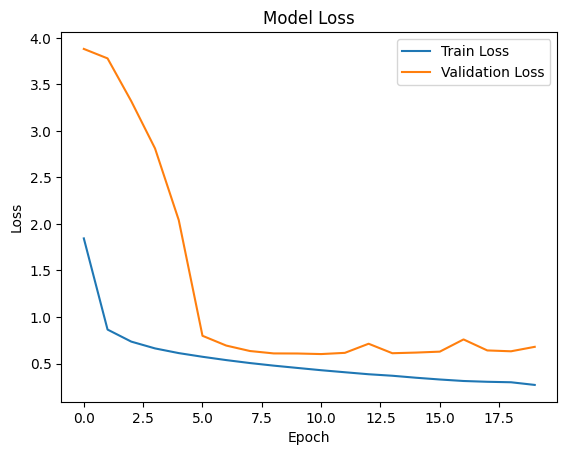

In [ ]:
plot_loss(history_v01)

### Gerando um novo coral

In [ ]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))  # Pré-processa os acordes iniciais para obter o arpejo
    arpegio = tf.reshape(arpegio, [1, -1])  # Redimensiona o arpejo para ter formato [1, comprimento]
    for chord in range(length):  # Loop para gerar acordes adicionais
        for note in range(4):  # Loop para gerar cada nota do acorde
            # Próxima nota com base nas previsões do modelo
            next_note = np.argmax(model.predict(arpegio, verbose=0), axis=-1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)  # Concatena a próxima nota ao arpejo
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)  # Ajusta os valores do arpejo
    return tf.reshape(arpegio, shape=[-1, 4])  # Redimensiona o arpejo para ter formato de acordes

Neste código, a função `generate_chorale` recebe um modelo treinado, uma lista de acordes iniciais (`seed_chords`) e o comprimento desejado para o coral resultante (`length`).

* Primeiro, os acordes iniciais são pré-processados para obter o arpejo correspondente usando a função preprocess. Os acordes iniciais são convertidos em arpejo, que é o formato esperado pelo modelo.

* Em seguida, o arpejo é redimensionado para ter formato [1, comprimento], para representar um único coral com o comprimento especificado.

* Em um loop externo, o código itera sobre cada acorde a ser gerado no coral resultante.

* Dentro desse loop externo, há um loop interno que itera sobre cada nota do acorde.

* A próxima nota é gerada com base nas previsões do modelo. A linha `next_note = np.argmax(model.predict(arpegio), axis=-1)[:1, -1:]` usa o modelo para prever a próxima nota do arpejo e seleciona apenas a última nota gerada.

* A próxima nota é concatenada ao arpejo usando `tf.concat`, expandindo o comprimento do arpejo.

* Após gerar todas as notas do acorde, o código ajusta os valores do arpejo usando `tf.where`, adicionando `min_note - 1` aos valores não nulos, para retornar as notas originais do coral.

* Por fim, o arpejo é redimensionado novamente para ter o formato de acordes [número_de_acordes, 4], onde cada acorde contém 4 notas.

Essa função gera um coral completo com base nos acordes iniciais fornecidos e usando o modelo para prever as próximas notas do arpejo.

Para testar essa função, precisamos de alguns acordes iniciais. Vamos usar os primeiros 16 acordes de um dos chorais de teste (na verdade, são apenas 4 acordes diferentes, cada um tocado 4 vezes):

In [ ]:
seed_chords = test_chorales[2][:136]
play_chords(seed_chords, amplitude=0.2)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
play_chords(test_chorales[2], filepath=f"{MUSIC_FILES_PATH}/test_chorales.wav")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(len(test_chorales[2]))

196


Vamos pedir à função para gerar mais 180 acordes, totalizando 196 acordes, ou seja, 49 compassos (assumindo 4 acordes por compasso, ou seja, uma assinatura de 4/4):

In [ ]:
new_chorale_v01 = generate_chorale(model_lstm_v01, seed_chords, COMPASS)
play_chords(new_chorale_v01, filepath=f"{MUSIC_FILES_PATH}/new_chorale_lstm_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(len(new_chorale_v01))

196


Essa abordagem costuma ser muito conservadora. De fato, o modelo não assume riscos, sempre escolhendo a nota com a pontuação mais alta. E como repetir a nota anterior geralmente soa bem o suficiente, é a opção menos arriscada.

Assim, o algoritmo tenderá a fazer as notas durarem cada vez mais. Isso acaba se tornando bastante monótono. Além disso, se você executar o modelo várias vezes, ele sempre gerará a mesma melodia.

Portanto, ao invés de sempre escolher a nota com a pontuação mais alta, iremos escolher a próxima nota aleatoriamente, de acordo com as probabilidades previstas.

Por exemplo, se o modelo prevê um C3 com 75% de probabilidade e um G3 com 25% de probabilidade, escolheremos uma dessas duas notas aleatoriamente, seguindo essas probabilidades.

Também adicionaremos um parâmetro de temperatura que controlará o quão "quente" (ousado) queremos que o sistema pareça. Uma temperatura alta fará com que as probabilidades previstas fiquem mais próximas umas das outras, reduzindo a probabilidade das notas mais prováveis e aumentando a probabilidade das menos prováveis.

### Comparações entre a criação e a música original




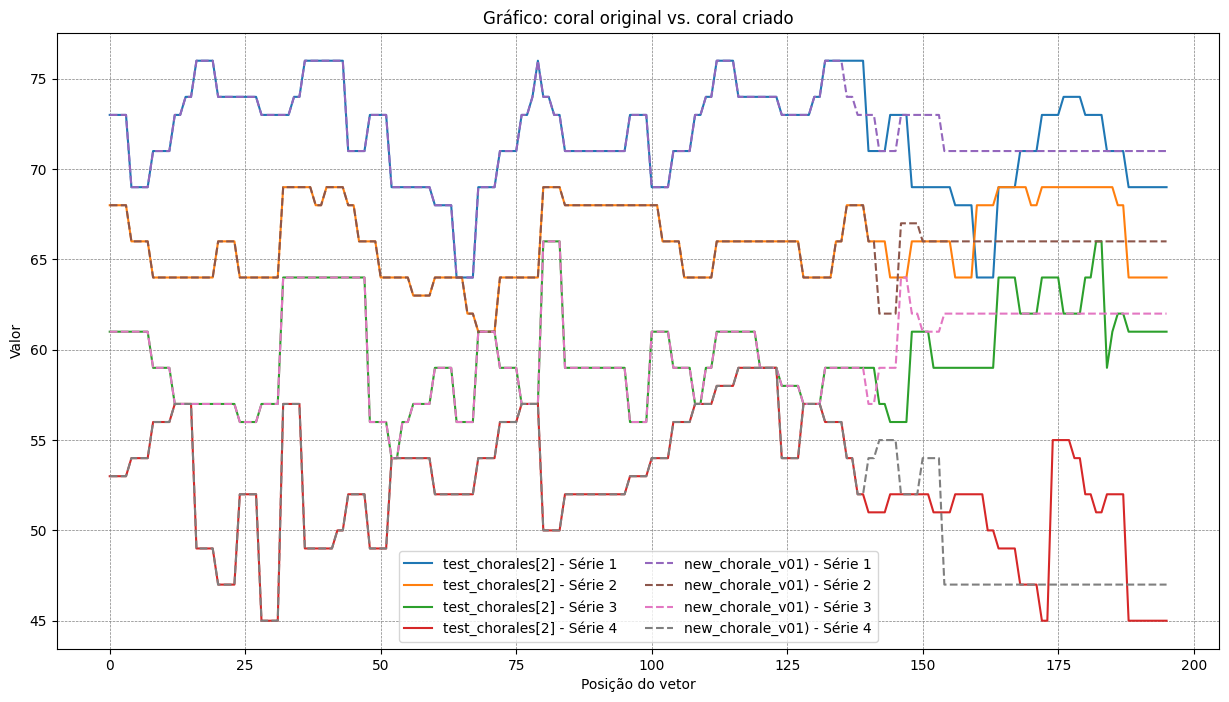

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v01)

## Criando o modelo - RNN - LSTM v.02

In [ ]:
n_embedding_dims = 5

model_lstm_v02 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(256, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(512, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(1024, return_sequences=True),
    keras.layers.Dense(n_notes, activation="softmax")
])

model_lstm_v02.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 5)           235       
                                                                 
 conv1d_28 (Conv1D)          (None, None, 64)          704       
                                                                 
 batch_normalization_28 (Bat  (None, None, 64)         256       
 chNormalization)                                                
                                                                 
 conv1d_29 (Conv1D)          (None, None, 128)         16512     
                                                                 
 batch_normalization_29 (Bat  (None, None, 128)        512       
 chNormalization)                                                
                                                                 
 conv1d_30 (Conv1D)          (None, None, 256)        

## 1. Propósito do Modelo:
Este modelo parece ser projetado para sequências, especificamente relacionadas a "notas", dado o nome `n_notes`. Pode ser para predição de séries temporais, geração de música ou algo semelhante.

### 2. Estrutura do Modelo:
#### a. Camada de Embedding:
Esta camada transforma índices inteiros (que podem representar notas musicais ou palavras) em vetores densos de tamanho fixo. Por exemplo, se tivermos 88 notas possíveis em um piano e cada nota é representada por um número inteiro único, a camada de embedding transformará cada número em um vetor de 5 dimensões (como definido por `n_embedding_dims`).

#### b. Camadas Conv1D:
Estas são camadas de convolução unidimensional. São usadas principalmente para sequências (como séries temporais ou sequências de texto). A propriedade `padding="causal"` garante que, ao processar uma dada entrada na sequência, a convolução não usa informações de entradas futuras, tornando-a adequada para tarefas como previsão.

As camadas subsequentes têm taxas de dilatação crescentes (2, 4, 8). Uma taxa de dilatação permite que a rede tenha uma visão mais ampla da entrada. Por exemplo, com uma taxa de dilatação de 2, a convolução "salta" cada outra entrada. Isso é útil para capturar padrões em diferentes escalas/temporalidades na sequência.

#### c. Camadas de Normalização em Lote:
Estas camadas são usadas para melhorar a convergência e estabilizar os pesos da rede durante o treinamento. Elas normalizam a ativação das camadas anteriores.

#### d. Camada LSTM:
LSTM é uma forma de rede neural recorrente (RNN) e é usada para sequências. Ela pode "lembrar" de informações de entradas anteriores e é, portanto, útil para capturar dependências temporais. A camada aqui tem 1024 unidades, o que significa que pode capturar uma boa quantidade de informação, mas também significa que terá muitos parâmetros.

#### e. Camada Densa:
Esta é uma camada de saída e tem uma unidade para cada possível "nota" (como definido por `n_notes`). A função de ativação softmax garante que a saída pode ser interpretada como probabilidades para cada classe de nota.

### 3. Resumo:
O modelo parece ser uma combinação de camadas convolucionais e uma camada LSTM para processar sequências de notas. As camadas convolucionais dilatadas podem ajudar a capturar padrões em diferentes escalas, enquanto a LSTM ajuda a modelar dependências temporais mais longas. A camada de saída sugere uma tarefa de classificação onde a rede tenta prever a próxima nota com base nas notas anteriores.

### Treinando o modelo

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model_lstm_v02.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history_v02 = model_lstm_v02.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20
98/98 [==============================] - 13s 87ms/step - loss: 1.1340 - accuracy: 0.7025 - val_loss: 4.3944 - val_accuracy: 0.0262
Epoch 2/20
98/98 [==============================] - 8s 79ms/step - loss: 0.5566 - accuracy: 0.8342 - val_loss: 3.9918 - val_accuracy: 0.0577
Epoch 3/20
98/98 [==============================] - 8s 80ms/step - loss: 0.4143 - accuracy: 0.8718 - val_loss: 3.9923 - val_accuracy: 0.1168
Epoch 4/20
98/98 [==============================] - 8s 81ms/step - loss: 0.3137 - accuracy: 0.9016 - val_loss: 3.6471 - val_accuracy: 0.1247
Epoch 5/20
98/98 [==============================] - 8s 81ms/step - loss: 0.2485 - accuracy: 0.9219 - val_loss: 2.9742 - val_accuracy: 0.3020
Epoch 6/20
98/98 [==============================] - 8s 83ms/step - loss: 0.1903 - accuracy: 0.9405 - val_loss: 1.0732 - val_accuracy: 0.6946
Epoch 7/20
98/98 [==============================] - 8s 83ms/step - loss: 0.1566 - accuracy: 0.9511 - val_loss: 0.7027 - val_accuracy: 0.8151
Epoch 8/20
9

### Salvando o modelo

In [ ]:
model_lstm_v02.save(filepath=f"{MODELS_PATH}/my_bach_model_lstm_v02.h5")
model_lstm_v02.evaluate(test_set)

34/34 [==============================] - 1s 28ms/step - loss: 0.8450 - accuracy: 0.8200


[0.845033586025238, 0.8200275897979736]

### Visualizando o treinamento

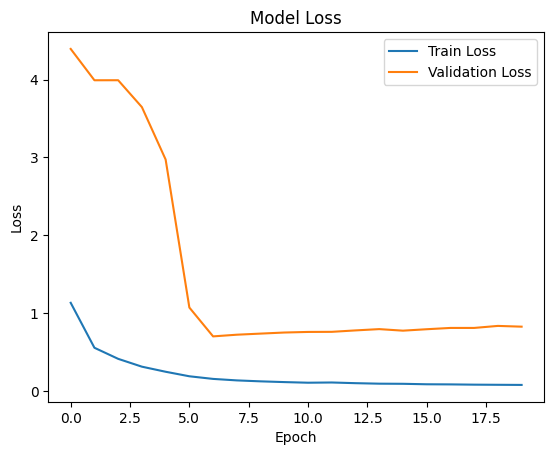

In [ ]:
plot_loss(history_v02)

### Gerando um novo coral

In [ ]:
new_chorale_v02 = generate_chorale(model_lstm_v02, seed_chords, COMPASS)
play_chords(new_chorale_v02, filepath=f"{MUSIC_FILES_PATH}/new_chorale__lstm_v02.wav")

Output hidden; open in https://colab.research.google.com to view.

### Comparações entre a criação e a música original




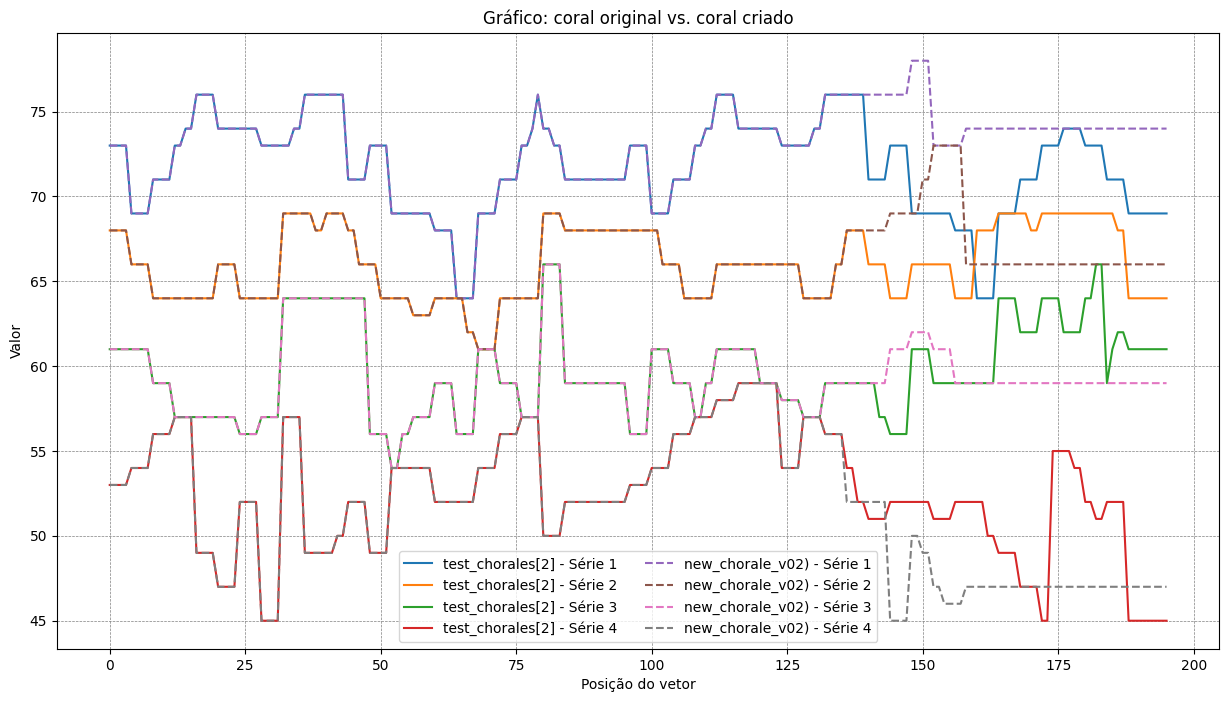

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v02)

## Criando o modelo - RNN - LSTM v.03

In [ ]:
n_embedding_dims = 5

model_lstm_v03 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims, input_shape=[None]),

    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),  # Adicionando dropout após a camada Conv1D

    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.Dropout(0.5),  # Maior dropout após a camada LSTM

    keras.layers.Dense(n_notes, activation="softmax", kernel_regularizer=keras.regularizers.l2(0.01))  # Adicionando regularização L2
])

model_lstm_v03.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 5)           235       
                                                                 
 conv1d_32 (Conv1D)          (None, None, 32)          352       
                                                                 
 batch_normalization_32 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 dropout_14 (Dropout)        (None, None, 32)          0         
                                                                 
 conv1d_33 (Conv1D)          (None, None, 48)          3120      
                                                                 
 batch_normalization_33 (Bat  (None, None, 48)         192       
 chNormalization)                                     

## 1. Propósito do Modelo:
Assim como o modelo anterior, este modelo também parece ser projetado para sequências, possivelmente relacionadas a "notas". Pode ser novamente para predição de séries temporais, geração de música, entre outros.

### 2. Estrutura do Modelo:
#### a. Camada de Embedding:
A mesma que o modelo anterior. Transforma índices inteiros em vetores densos de tamanho fixo.

#### b. Sequência de Camadas Conv1D:
- Começa com 32 filtros e avança progressivamente em complexidade até 96 filtros.
- Como antes, a opção `padding="causal"` garante uma convolução que não olha para o futuro.
- As taxas de dilatação crescentes (2, 4, 8) permitem à rede capturar padrões em diferentes escalas/temporalidades na sequência.

#### c. Camadas de Normalização em Lote:
Essas camadas, novamente, buscam estabilizar as ativações e acelerar o treinamento.

#### d. Camadas de Dropout:
Estas são uma nova adição em comparação ao modelo anterior. Dropout é uma técnica de regularização que "desativa" aleatoriamente um subconjunto de neurônios durante o treinamento. Isso ajuda a evitar o overfitting. Os valores (0.3 e 0.5) representam a fração de entradas a serem zeradas.

#### e. Camada LSTM:
Tem 256 unidades, menos que o modelo anterior. Isso significa que pode haver menos capacidade de memória/modelo, mas também menos parâmetros.

#### f. Camada Densa:
Além de ser uma camada de saída com unidades softmax, uma nova adição aqui é a regularização L2. A regularização L2 penaliza os pesos grandes, o que pode ajudar a evitar o overfitting. O valor 0.01 é o fator de regularização, determinando quão forte é essa penalização.

### 3. Resumo:
O modelo parece ser uma variante do modelo anterior com uma estrutura de camadas convolucionais ligeiramente diferente. As principais adições incluem camadas de dropout para ajudar na regularização e uma regularização L2 na camada de saída. O objetivo destas adições é, muito provavelmente, melhorar a generalização do modelo ao evitar o overfitting.

### Treinando o modelo

In [ ]:
# Para a compilação e treinamento:
optimizer = keras.optimizers.Adam()
model_lstm_v03.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lr_schedule = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_lstm_v03.h5", save_best_only=True)


history_v03 = model_lstm_v03.fit(train_set, epochs=20, validation_data=valid_set,
                            callbacks=[early_stopping, lr_schedule, checkpoint_cb])

Epoch 1/20
98/98 [==============================] - 5s 24ms/step - loss: 3.0725 - accuracy: 0.2822 - val_loss: 3.2749 - val_accuracy: 0.1584 - lr: 0.0010
Epoch 2/20
98/98 [==============================] - 2s 15ms/step - loss: 1.7651 - accuracy: 0.5800 - val_loss: 2.7744 - val_accuracy: 0.1808 - lr: 0.0010
Epoch 3/20
98/98 [==============================] - 2s 15ms/step - loss: 1.4810 - accuracy: 0.6753 - val_loss: 2.3008 - val_accuracy: 0.2957 - lr: 0.0010
Epoch 4/20
98/98 [==============================] - 1s 15ms/step - loss: 1.3706 - accuracy: 0.7108 - val_loss: 1.7203 - val_accuracy: 0.5376 - lr: 0.0010
Epoch 5/20
98/98 [==============================] - 1s 15ms/step - loss: 1.3119 - accuracy: 0.7236 - val_loss: 1.3422 - val_accuracy: 0.7066 - lr: 0.0010
Epoch 6/20
98/98 [==============================] - 1s 15ms/step - loss: 1.2757 - accuracy: 0.7312 - val_loss: 1.1728 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 7/20
98/98 [==============================] - 2s 16ms/step - loss: 1.2

### Salvando o modelo

In [ ]:
model_lstm_v03.save(filepath=f"{MODELS_PATH}/my_bach_model_lstm_v03.h5")
model_lstm_v03.evaluate(test_set)

34/34 [==============================] - 0s 7ms/step - loss: 1.0779 - accuracy: 0.7594


[1.077886700630188, 0.7594024538993835]

### Visualizando o treinamento

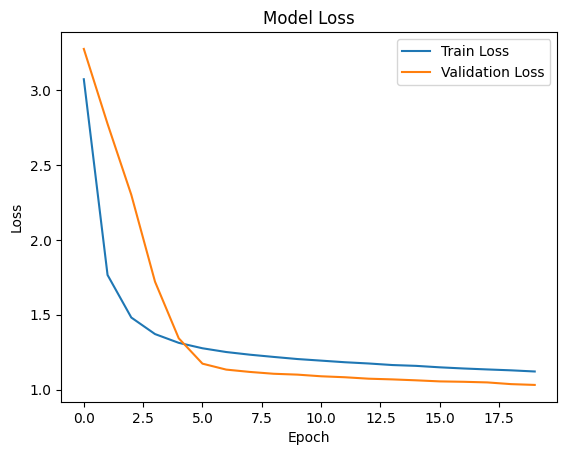

In [ ]:
plot_loss(history_v03)

### Gerando um novo coral

In [ ]:
new_chorale_v03 = generate_chorale(model_lstm_v03, seed_chords, COMPASS)
play_chords(new_chorale_v03, filepath=f"{MUSIC_FILES_PATH}/new_chorale_lstm_v03.wav")

Output hidden; open in https://colab.research.google.com to view.

### Comparações entre a criação e a música original




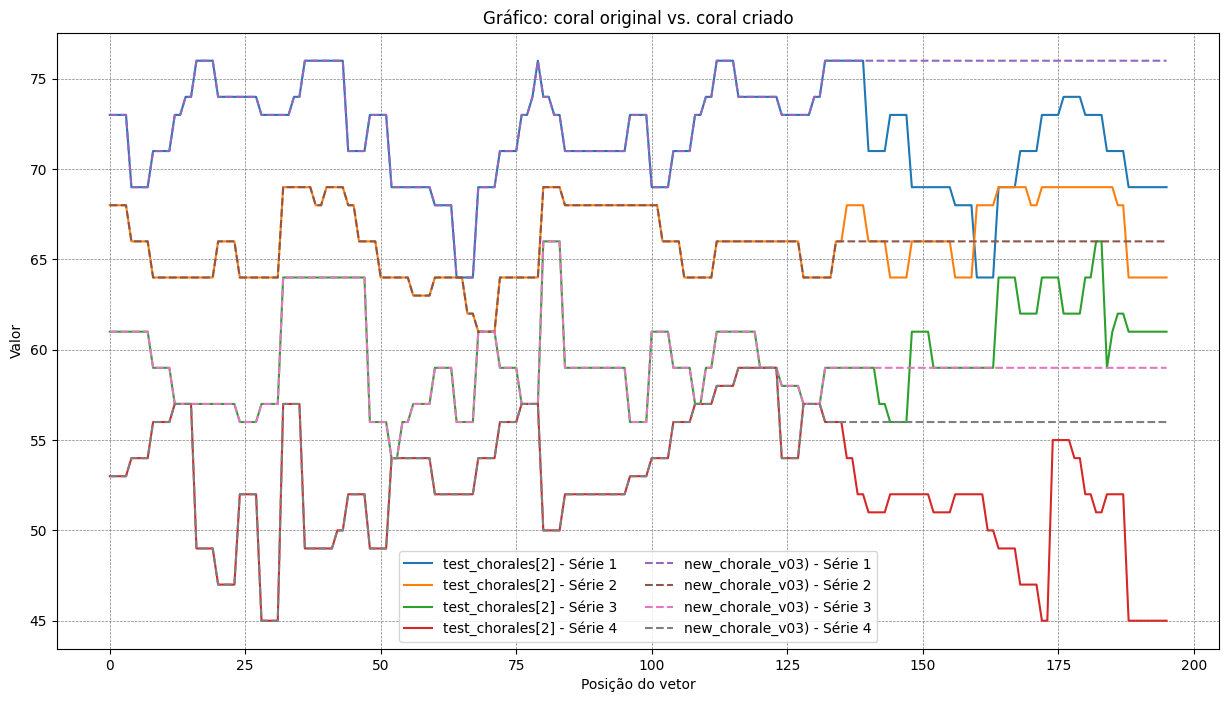

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v03)

## Criando o modelo - RNN - LSTM v.04

In [ ]:
n_embedding_dims = 5

model_lstm_v04m_v04 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims, input_shape=[None]),

    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(n_notes, activation="softmax")
])

model_lstm_v04.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 5)           235       
                                                                 
 conv1d_36 (Conv1D)          (None, None, 32)          352       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, None, 32)          0         
                                                                 
 batch_normalization_36 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, None, 32)          0         
                                                                 
 conv1d_37 (Conv1D)          (None, None, 48)          3120      
                                                      

## 1. Propósito do Modelo:
Este modelo, assim como os anteriores, é projetado para a geração ou sequenciamento de notas musicais, possivelmente sendo usado para a geração autônoma de música.

### 2. Estrutura do Modelo:
#### a. Camada de Embedding:
- Igual aos modelos anteriores. Transforma índices inteiros em vetores densos de dimensão definida como `n_embedding_dims`.

#### b. Sequência de Camadas Conv1D:
- Mantém uma estrutura similar ao modelo_v03 com 32, 48, 64 e 96 filtros.
- A opção `padding="causal"` garante que a convolução não olhe para o futuro.
- Taxas de dilatação crescentes são usadas para reconhecer padrões em diferentes escalas temporais.

#### c. Camadas de Normalização em Lote:
- Estão presentes após cada camada Conv1D. Elas estabilizam as ativações e podem acelerar o treinamento.

#### d. Camadas de Dropout:
- Estas camadas desativam aleatoriamente um subconjunto de neurônios durante o treinamento, a uma taxa definida. Auxiliam na regularização do modelo.

#### e. Camadas LeakyReLU:
- Foram introduzidas após cada camada Conv1D para introduzir não-linearidade. Diferente da ativação ReLU tradicional, ela permite que pequenos gradientes negativos passem, o que pode ajudar na prevenção de neurônios "mortos" durante o treinamento.

#### f. Camadas LSTM:
- Duas camadas LSTM são utilizadas em sequência. A primeira tem 256 unidades e a segunda 128 unidades. Ambas retornam sequências, permitindo que uma LSTM alimente a próxima.
- Essas camadas capturam dependências temporais nos dados.

#### g. Camada Densa:
- A camada de saída densa possui uma função de ativação softmax e retorna uma distribuição de probabilidade sobre possíveis notas musicais.

### 3. Resumo:
O modelo_v04 é uma evolução dos modelos anteriores com foco em melhorar a capacidade de sequenciamento e generalização. Introduz-se a ativação `LeakyReLU` após as camadas convolucionais para evitar potenciais neurônios "mortos" e melhorar a não-linearidade. Além disso, uma segunda camada LSTM foi adicionada para aprimorar a capacidade do modelo de reconhecer dependências temporais de longo alcance nos dados. A expectativa é que essas mudanças permitam uma geração de música mais coerente e rica em detalhes.

### Treinando o modelo

In [ ]:
optimizer = keras.optimizers.Adam()
model_lstm_v04.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lr_schedule = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_lstm_v04.h5", save_best_only=True)

history_v04 = model_lstm_v04.fit(train_set, epochs=20, validation_data=valid_set,
                            callbacks=[early_stopping, lr_schedule, checkpoint_cb])

Epoch 1/20
98/98 [==============================] - 7s 33ms/step - loss: 3.0662 - accuracy: 0.1580 - val_loss: 3.6349 - val_accuracy: 0.0476 - lr: 0.0010
Epoch 2/20
98/98 [==============================] - 2s 21ms/step - loss: 1.7853 - accuracy: 0.5230 - val_loss: 3.1403 - val_accuracy: 0.1277 - lr: 0.0010
Epoch 3/20
98/98 [==============================] - 2s 21ms/step - loss: 1.2691 - accuracy: 0.6740 - val_loss: 2.7466 - val_accuracy: 0.2859 - lr: 0.0010
Epoch 4/20
98/98 [==============================] - 2s 21ms/step - loss: 1.1240 - accuracy: 0.7127 - val_loss: 2.1157 - val_accuracy: 0.4469 - lr: 0.0010
Epoch 5/20
98/98 [==============================] - 2s 21ms/step - loss: 1.0477 - accuracy: 0.7296 - val_loss: 1.3083 - val_accuracy: 0.6512 - lr: 0.0010
Epoch 6/20
98/98 [==============================] - 2s 20ms/step - loss: 0.9931 - accuracy: 0.7406 - val_loss: 0.9127 - val_accuracy: 0.7621 - lr: 0.0010
Epoch 7/20
98/98 [==============================] - 2s 21ms/step - loss: 0.9

### Salvando o modelo

In [ ]:
model_lstm_v04.save(filepath=f"{MODELS_PATH}/my_bach_model_lstm_v04.h5")
model_lstm_v04.evaluate(test_set)

34/34 [==============================] - 0s 9ms/step - loss: 0.6158 - accuracy: 0.8167


[0.615766167640686, 0.8166579604148865]

### Visualizando o treinamento

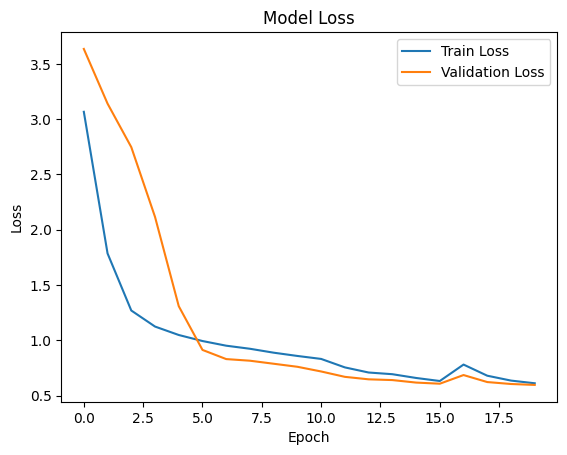

In [ ]:
plot_loss(history_v04)

### Gerando um novo coral

In [ ]:
new_chorale_v04 = generate_chorale(model_lstm_v04, seed_chords, COMPASS)
play_chords(new_chorale_v04, filepath=f"{MUSIC_FILES_PATH}/new_chorale_lstm_v04.wav")

Output hidden; open in https://colab.research.google.com to view.

### Comparações entre a criação e a música original




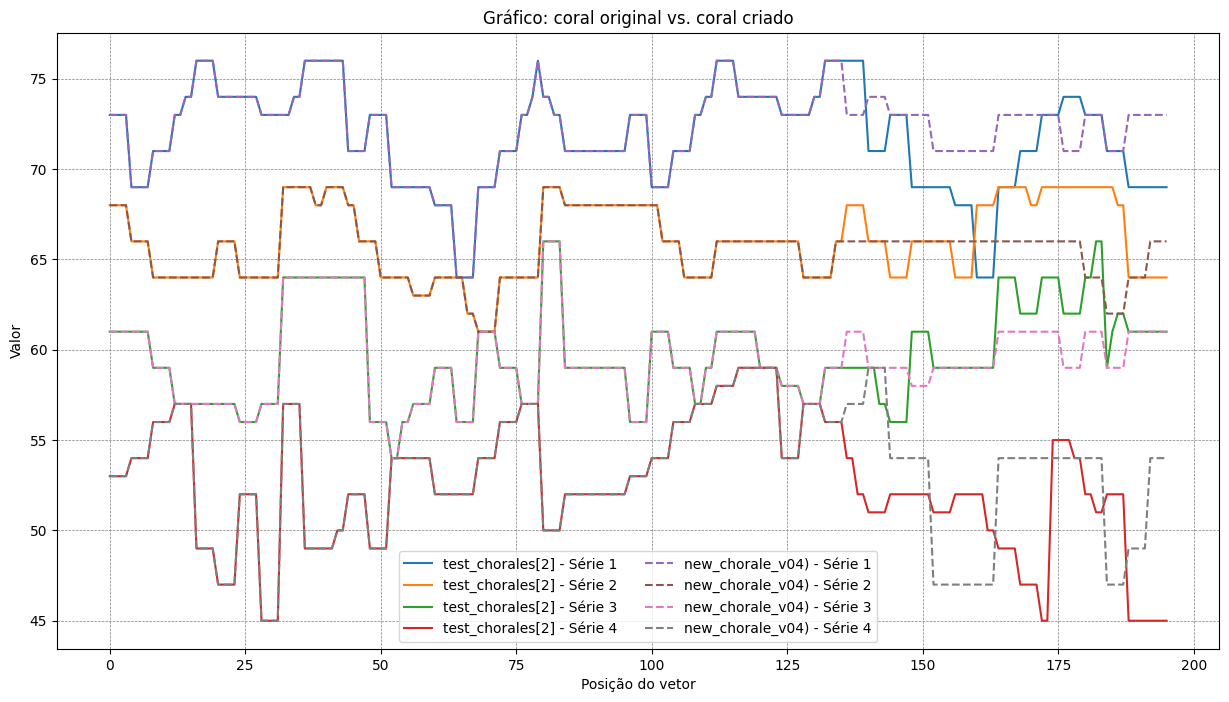

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v04)

## Criando o modelo - RNN - GRU v.01

In [ ]:
n_embedding_dims = 5

model_gru_v01 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims, input_shape=[None]),
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.GRU(256, return_sequences=True),  # Aqui é onde substituímos LSTM por GRU
    keras.layers.Dense(n_notes, activation="softmax")
])

model_gru_v01.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 5)           235       
                                                                 
 conv1d_40 (Conv1D)          (None, None, 32)          352       
                                                                 
 batch_normalization_40 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 conv1d_41 (Conv1D)          (None, None, 48)          3120      
                                                                 
 batch_normalization_41 (Bat  (None, None, 48)         192       
 chNormalization)                                                
                                                                 
 conv1d_42 (Conv1D)          (None, None, 64)        

## 1. Propósito do Modelo:
Este modelo, como os anteriores, parece ser projetado para lidar com sequências relacionadas a "notas". Pode ser utilizado para várias tarefas que envolvam sequências, como predição de séries temporais, geração de música, entre outras.

### 2. Estrutura do Modelo:

#### a. **Camada de Embedding**:
- Esta camada transforma índices inteiros (provavelmente representando notas) em vetores densos fixos de tamanho `n_embedding_dims`, neste caso 5.

#### b. **Sequência de Camadas Conv1D**:
- Estas camadas são utilizadas para detectar padrões locais/temporais nas sequências.
- Há 4 camadas `Conv1D` com diferentes números de filtros (32, 48, 64 e 96).
- A opção `padding="causal"` garante que a convolução não tenha informações do futuro.
- O uso de taxas de dilatação crescentes (1, 2, 4 e 8) permite que as camadas reconheçam padrões em diferentes escalas de tempo.

#### c. **Camadas de Normalização em Lote**:
- Estas camadas estabilizam as ativações e aceleram o treinamento. São colocadas após cada camada `Conv1D`.

#### d. **Camada GRU**:
- Este é um tipo diferente de célula de rede neural recorrente, semelhante ao LSTM, mas um pouco mais simples e, frequentemente, mais rápido.
- Aqui, temos uma camada GRU com 256 unidades que retorna sequências, o que significa que ela devolve um valor para cada timestep e não apenas para o último.
- A grande diferença deste modelo em relação aos anteriores é a troca de uma LSTM por uma GRU.

#### e. **Camada Densa**:
- Finalmente, temos uma camada densa com ativação softmax, que retorna uma distribuição de probabilidade sobre as "notas" para cada timestep.

### 3. Resumo:
O modelo `model_gru_v01` é uma rede que combina camadas convolucionais para detectar padrões locais e uma camada recorrente (neste caso, GRU) para modelar dependências temporais de longo prazo. É uma arquitetura que parece otimizada para reconhecer padrões complexos em sequências temporais, como pode ser necessário na geração de música ou outras tarefas relacionadas.

### Treinando o modelo

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model_gru_v01.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history_gru_v01 = model_gru_v01.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20
98/98 [==============================] - 6s 25ms/step - loss: 1.6855 - accuracy: 0.5722 - val_loss: 4.2889 - val_accuracy: 0.0414
Epoch 2/20
98/98 [==============================] - 2s 17ms/step - loss: 0.8659 - accuracy: 0.7674 - val_loss: 4.4692 - val_accuracy: 0.0705
Epoch 3/20
98/98 [==============================] - 2s 17ms/step - loss: 0.7355 - accuracy: 0.7930 - val_loss: 3.3708 - val_accuracy: 0.1068
Epoch 4/20
98/98 [==============================] - 2s 17ms/step - loss: 0.6597 - accuracy: 0.8093 - val_loss: 3.0868 - val_accuracy: 0.1877
Epoch 5/20
98/98 [==============================] - 2s 17ms/step - loss: 0.6020 - accuracy: 0.8224 - val_loss: 2.0793 - val_accuracy: 0.3962
Epoch 6/20
98/98 [==============================] - 2s 17ms/step - loss: 0.5564 - accuracy: 0.8327 - val_loss: 1.1329 - val_accuracy: 0.6393
Epoch 7/20
98/98 [==============================] - 2s 17ms/step - loss: 0.5194 - accuracy: 0.8413 - val_loss: 0.6966 - val_accuracy: 0.7971
Epoch 8/20
98

### Salvando o modelo

In [ ]:
model_gru_v01.save(filepath=f"{MODELS_PATH}/my_bach_model_gru_v01.h5")
model_gru_v01.evaluate(test_set)

34/34 [==============================] - 0s 7ms/step - loss: 0.7008 - accuracy: 0.8118


[0.7007644772529602, 0.8118288516998291]

### Visualizando o treinamento

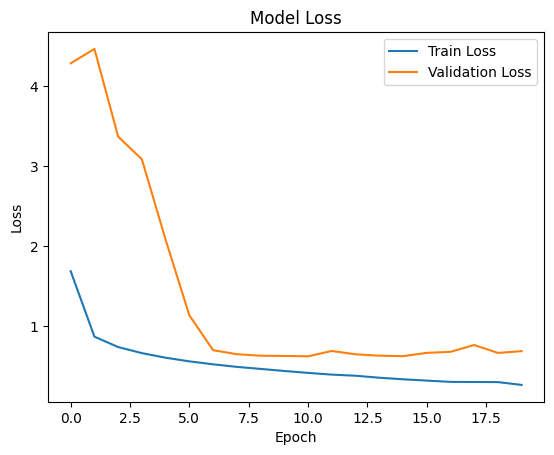

In [ ]:
plot_loss(history_gru_v01)

### Gerando um novo coral

In [ ]:
new_chorale_gru_v01 = generate_chorale(model_gru_v01, seed_chords, COMPASS)
play_chords(new_chorale_gru_v01, filepath=f"{MUSIC_FILES_PATH}/new_chorale_gru_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

### Comparações entre a criação e a música original




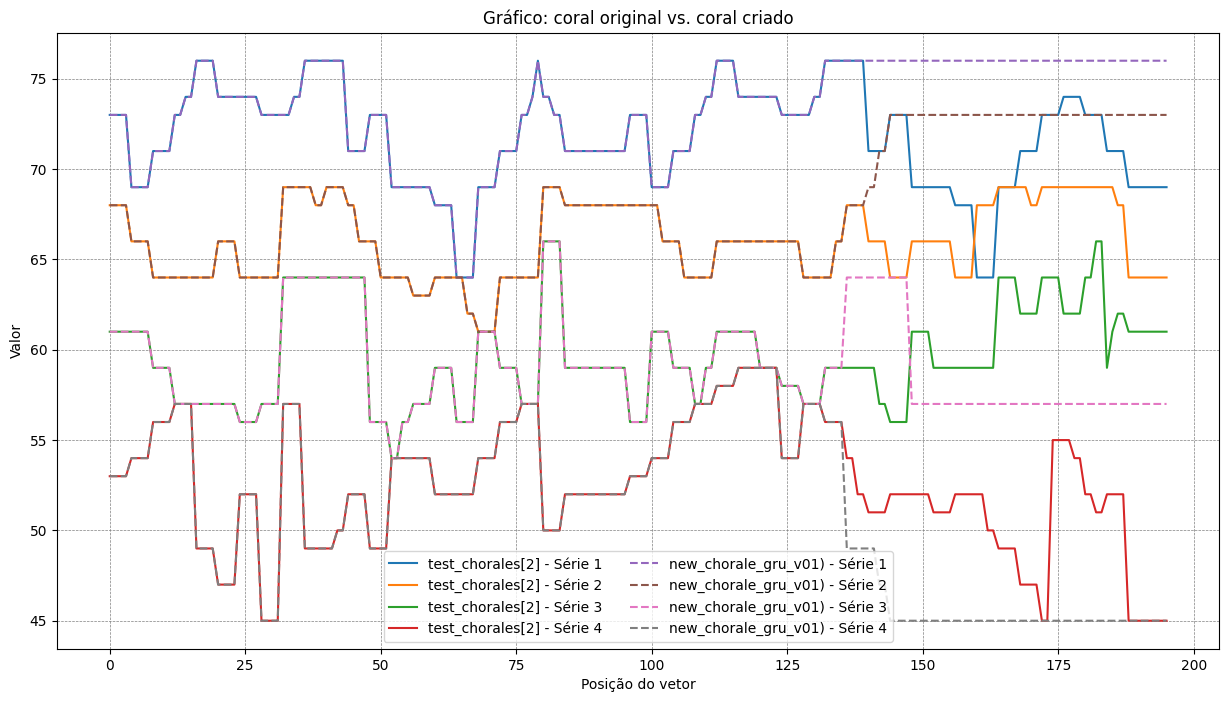

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_gru_v01)

## Criando o modelo - RNN - GRU v.02

In [ ]:
n_embedding_dims = 5

model_gru_v02 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(256, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(512, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.GRU(2048, return_sequences=True),
    keras.layers.Dense(n_notes, activation="softmax")
])

model_gru_v02.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 5)           235       
                                                                 
 conv1d_44 (Conv1D)          (None, None, 64)          704       
                                                                 
 batch_normalization_44 (Bat  (None, None, 64)         256       
 chNormalization)                                                
                                                                 
 conv1d_45 (Conv1D)          (None, None, 128)         16512     
                                                                 
 batch_normalization_45 (Bat  (None, None, 128)        512       
 chNormalization)                                                
                                                                 
 conv1d_46 (Conv1D)          (None, None, 256)       

## 1. Propósito do Modelo:
Assim como os modelos anteriores, este modelo é projetado para lidar com sequências que estão relacionadas a "notas". Ele pode ser utilizado para uma série de tarefas que envolvam sequências, como predição de séries temporais, geração de música, entre outras.

### 2. Estrutura do Modelo:

#### a. **Camada de Embedding**:
- Transforma índices inteiros (que provavelmente representam notas) em vetores densos fixos de tamanho `n_embedding_dims` (5 neste caso). É uma forma de representar cada nota como um vetor contínuo, facilitando o aprendizado de padrões complexos associados a essas notas.

#### b. **Sequência de Camadas Conv1D**:
- Detecta padrões locais/temporais nas sequências.
- Existem 4 camadas `Conv1D` neste modelo, com diferentes números de filtros: 64, 128, 256 e 512, respectivamente.
- O `padding="causal"` garante que a convolução não veja informações futuras, o que é essencial para muitas tarefas temporais.
- O modelo utiliza taxas de dilatação crescentes (`dilation_rate`) nas camadas Conv1D: 1 (padrão), 2, 4 e 8. A dilatação permite que as camadas reconheçam padrões em diferentes escalas temporais.

#### c. **Camadas de Normalização em Lote**:
- Estabilizam as ativações e podem acelerar o treinamento. Elas são colocadas após cada camada `Conv1D`.

#### d. **Camada GRU**:
- A GRU (Gated Recurrent Unit) é uma célula de rede neural recorrente semelhante ao LSTM, mas com uma estrutura mais simples. É utilizada para modelar dependências temporais.
- Aqui, temos uma camada GRU com 1024 unidades. Esta camada retorna sequências, ou seja, para cada etapa de tempo na sequência de entrada, ela retorna uma saída.

#### e. **Camada Densa**:
- Uma camada densa com ativação softmax. Como em modelos anteriores, isso retorna uma distribuição de probabilidade sobre as "notas" para cada etapa de tempo na sequência.

### 3. Resumo:
O `model_lstm_v02` é uma combinação de camadas convolucionais e recorrentes. Ele utiliza camadas Conv1D para detectar padrões locais nas sequências e uma camada GRU para modelar dependências de longo prazo. Comparado com `model_gru_v01`, o `model_lstm_v02` tem mais camadas convolucionais e uma camada GRU maior, o que sugere uma capacidade maior de modelagem e, possivelmente, uma necessidade de mais dados para treinamento adequado.

### Treinando o modelo

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model_gru_v02.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history_gru_v02 = model_gru_v02.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20
98/98 [==============================] - 22s 185ms/step - loss: 0.9725 - accuracy: 0.7416 - val_loss: 3.5965 - val_accuracy: 0.0793
Epoch 2/20
98/98 [==============================] - 18s 184ms/step - loss: 0.4768 - accuracy: 0.8560 - val_loss: 3.9080 - val_accuracy: 0.0860
Epoch 3/20
98/98 [==============================] - 17s 179ms/step - loss: 0.3248 - accuracy: 0.8992 - val_loss: 4.2470 - val_accuracy: 0.1410
Epoch 4/20
98/98 [==============================] - 17s 176ms/step - loss: 0.2304 - accuracy: 0.9288 - val_loss: 3.8578 - val_accuracy: 0.1394
Epoch 5/20
98/98 [==============================] - 17s 176ms/step - loss: 0.1822 - accuracy: 0.9443 - val_loss: 2.6012 - val_accuracy: 0.3461
Epoch 6/20
98/98 [==============================] - 18s 179ms/step - loss: 0.1520 - accuracy: 0.9537 - val_loss: 1.1024 - val_accuracy: 0.6851
Epoch 7/20
98/98 [==============================] - 18s 180ms/step - loss: 0.1372 - accuracy: 0.9585 - val_loss: 0.7684 - val_accuracy: 0.7945

### Salvando o modelo

In [ ]:
model_gru_v02.save(filepath=f"{MODELS_PATH}/my_bach_model_gru_v02.h5")
model_gru_v02.evaluate(test_set)

34/34 [==============================] - 2s 59ms/step - loss: 0.9101 - accuracy: 0.8140


[0.9101083874702454, 0.8140037059783936]

### Visualizando o treinamento

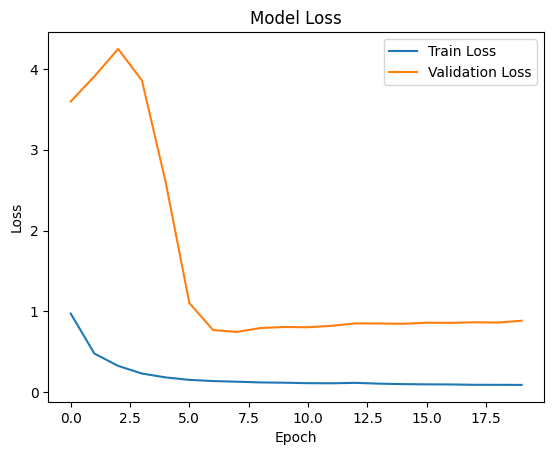

In [ ]:
plot_loss(history_gru_v02)

### Gerando um novo coral

In [ ]:
new_chorale_gru_v02 = generate_chorale(model_gru_v02, seed_chords, COMPASS)
play_chords(new_chorale_gru_v02, filepath=f"{MUSIC_FILES_PATH}/new_chorale_gru_v02.wav")

Output hidden; open in https://colab.research.google.com to view.

### Comparações entre a criação e a música original




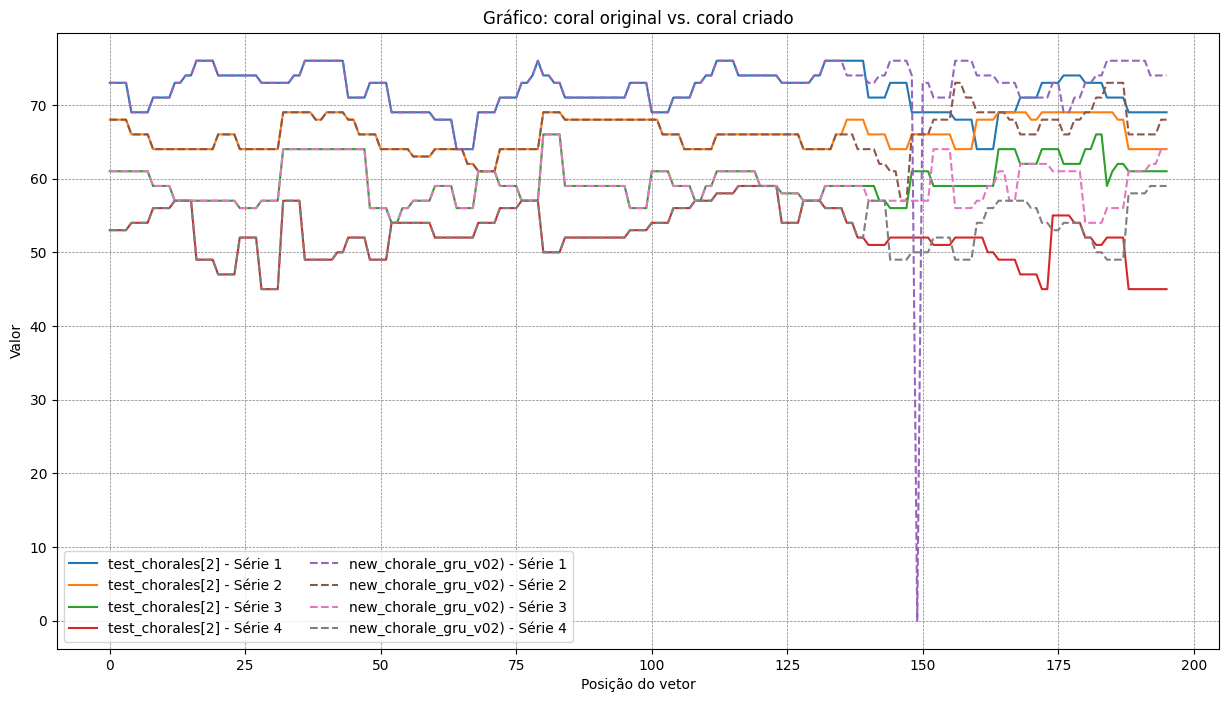

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_gru_v02)

## Criando o modelo - Transformer v.01

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return position * angle_rates

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model
        )

        # Instrução de impressão para verificar o conteúdo de angle_rads
        print(angle_rads)

        # apply sin to even indices in the array; 2i
        sines = tf.math.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = np.zeros(angle_rads.shape)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines
        pos_encoding = pos_encoding[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

n_embedding_dims = 128
position = 2000  # ou qualquer valor suficientemente grande para sua sequência
pos_enc = PositionalEncoding(position, n_embedding_dims)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 8.65964323e-01 ... 1.33352143e-04
  1.15478198e-04 1.15478198e-04]
 [2.00000000e+00 2.00000000e+00 1.73192865e+00 ... 2.66704286e-04
  2.30956397e-04 2.30956397e-04]
 ...
 [1.99700000e+03 1.99700000e+03 1.72933075e+03 ... 2.66304230e-01
  2.30609962e-01 2.30609962e-01]
 [1.99800000e+03 1.99800000e+03 1.73019672e+03 ... 2.66437582e-01
  2.30725441e-01 2.30725441e-01]
 [1.99900000e+03 1.99900000e+03 1.73106268e+03 ... 2.66570934e-01
  2.30840919e-01 2.30840919e-01]]


## Propósito do modelo

O código implementa uma técnica para Transformers chamada "Positional Encoding". Esta técnica é usada para dar à rede uma noção da posição dos elementos em uma sequência.

###`PositionalEncoding` Classe:

#### 1. `__init__`:
- Esta função inicializa a classe. Ela calcula o positional encoding e o armazena no atributo `self.pos_encoding`.

#### 2. `get_angles`:
- Esta função é usada para calcular os ângulos que serão usados no positional encoding. A ideia principal é que as taxas de ângulo diminuam exponencialmente com a profundidade `i` (eixo da dimensão do modelo `d_model`).
- A fórmula `1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))` é derivada diretamente do papel Transformer original.

#### 3. `positional_encoding`:
- Esta função calcula o positional encoding.
- Ela primeiro chama `get_angles` para obter os ângulos.
- O seno é aplicado aos índices pares (2i) do array e o cosseno aos índices ímpares (2i+1).
- A codificação posicional final é uma combinação desses valores seno e cosseno.

#### 4. `call`:
- Esta é a função que seria chamada quando o layer é usado em uma sequência de entrada.
- Ela simplesmente adiciona o positional encoding à entrada. A adição é feita para os primeiros `tf.shape(inputs)[1]` elementos, o que garante que o positional encoding é aplicado corretamente mesmo se a entrada for mais curta que o positional encoding predefinido.

### Uso:

- Você definiu `n_embedding_dims` como 4, o que indica que a dimensão do embedding de cada palavra/token na sequência é 4.
- `position` é definido como 500, o que significa que o positional encoding será calculado para sequências de até 500 tokens.
- `pos_enc` é uma instância da classe `PositionalEncoding`. Sempre que você quiser aplicar positional encoding a uma sequência de entrada, você pode simplesmente usar `pos_enc(sua_sequência)`.

### Resumo:

O positional encoding é crucial para modelos Transformer porque eles não têm noção inerente da ordem ou posição de elementos em uma sequência. Ao adicionar esta codificação, estamos dando ao modelo uma forma de considerar a posição dos tokens ao fazer cálculos.

### Treinando o modelo

In [ ]:
import keras
from keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout
from keras import regularizers

# Hiperparâmetros e Configuração
n_embedding_dims = 128  # Aumentando a dimensão de incorporação
n_notes = 47  # Ajuste de acordo com o seu conjunto de dados
#position = 500

inputs = Input(shape=[None])

# Embedding layers
x = Embedding(input_dim=n_notes, output_dim=n_embedding_dims)(inputs)
pos_enc = PositionalEncoding(position, n_embedding_dims)
x = pos_enc(x)

# Transformer block
x = LayerNormalization()(x)
attention_output = MultiHeadAttention(num_heads=8, key_dim=n_embedding_dims)(x, x)
x = keras.layers.Add()([x, attention_output])
x = Dropout(0.2)(x)

x = LayerNormalization()(x)

# Adicionando mais camadas Densas
x = Dense(1024, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)

x = Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)

x = Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)

outputs = Dense(n_notes, activation="softmax")(x)

model_t_v01 = keras.Model(inputs=inputs, outputs=outputs)

optimizer = keras.optimizers.Adam()
model_t_v01.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lr_schedule = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_v05.h5", save_best_only=True)

# Treinamento
history_t_v01 = model_t_v01.fit(train_set, epochs=20,  # Aumentando as épocas para um treinamento mais longo
                                validation_data=valid_set, callbacks=[early_stopping, lr_schedule, checkpoint_cb])

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 8.65964323e-01 ... 1.33352143e-04
  1.15478198e-04 1.15478198e-04]
 [2.00000000e+00 2.00000000e+00 1.73192865e+00 ... 2.66704286e-04
  2.30956397e-04 2.30956397e-04]
 ...
 [1.99700000e+03 1.99700000e+03 1.72933075e+03 ... 2.66304230e-01
  2.30609962e-01 2.30609962e-01]
 [1.99800000e+03 1.99800000e+03 1.73019672e+03 ... 2.66437582e-01
  2.30725441e-01 2.30725441e-01]
 [1.99900000e+03 1.99900000e+03 1.73106268e+03 ... 2.66570934e-01
  2.30840919e-01 2.30840919e-01]]
Epoch 1/20
98/98 [==============================] - 4s 31ms/step - loss: 6.3667 - accuracy: 0.0713 - val_loss: 3.5116 - val_accuracy: 0.0785 - lr: 0.0010
Epoch 2/20
98/98 [==============================] - 3s 26ms/step - loss: 3.2539 - accuracy: 0.0972 - val_loss: 3.0933 - val_accuracy: 0.1214 - lr: 0.0010
Epoch 3/20
98/98 [==============================] - 3s 26ms/step - loss: 2.9313 - accuracy: 

### Salvando o modelo

In [ ]:
model_t_v01.save(filepath=f"{MODELS_PATH}/my_bach_model_transf_v01.h5")
model_t_v01.evaluate(test_set)

34/34 [==============================] - 0s 10ms/step - loss: 0.8221 - accuracy: 0.7975


[0.8221123218536377, 0.7975346446037292]

### Visualizando o treinameto

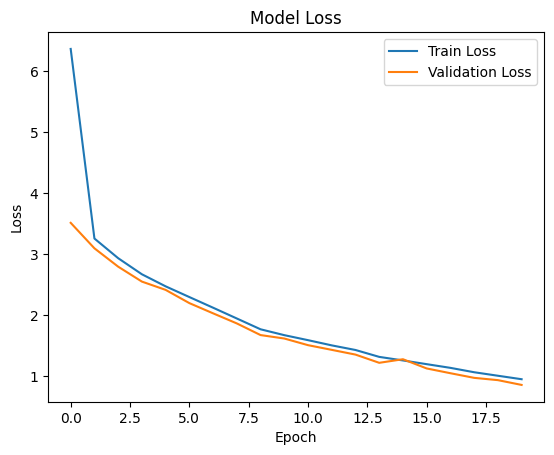

In [ ]:
plot_loss(history_t_v01)

### Gerando um outro coral

In [ ]:
new_chorale_t_v01 = generate_chorale(model_t_v01, seed_chords, COMPASS)
play_chords(new_chorale_t_v01, filepath=f"{MUSIC_FILES_PATH}/new_chorale_transf_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

### Comparações entre a criação e a música original




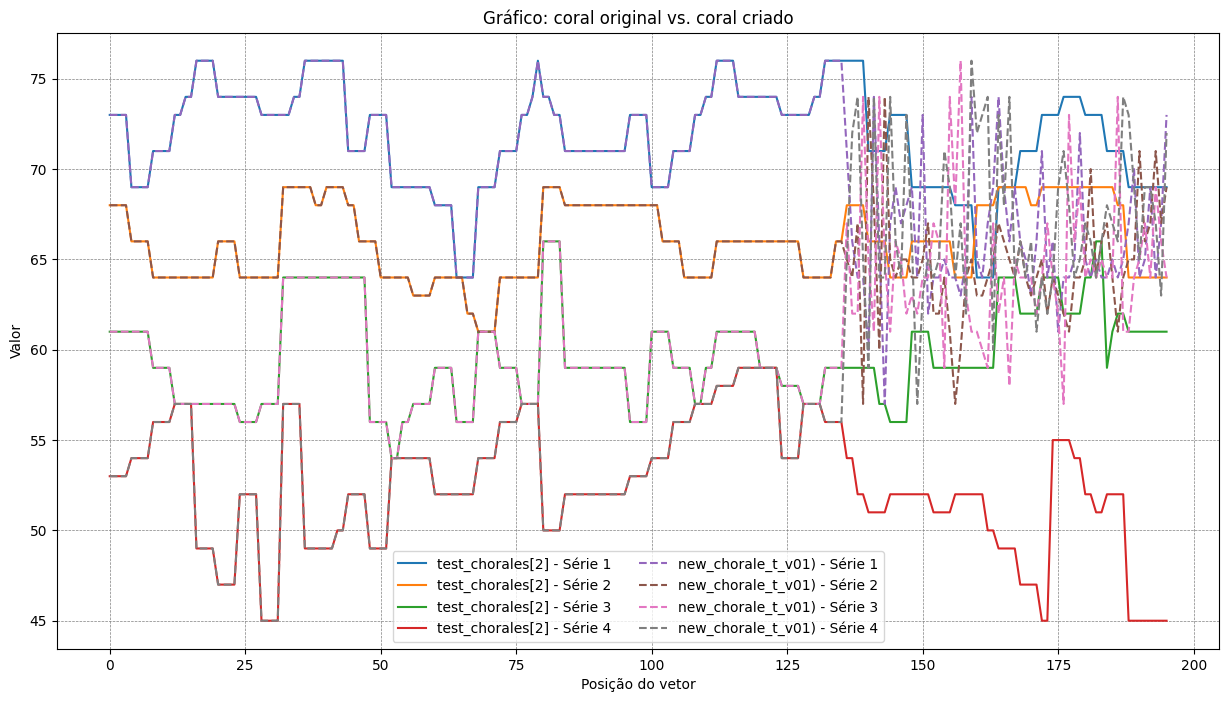

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_t_v01)

## Criando um modelo - GAN

In [ ]:
# Gerador
def build_generator(latent_dim=100, output_dim=32):
    model = keras.models.Sequential([
        keras.layers.Dense(128, activation='relu', input_dim=latent_dim),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(output_dim, activation='tanh')
    ])
    return model

# Discriminador
def build_discriminator(input_dim=32):
    model = keras.models.Sequential([
        keras.layers.Dense(512, activation='relu', input_dim=input_dim),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

Este código define duas funções para construir os componentes fundamentais de uma Rede Adversarial Generativa (GAN): o Gerador e o Discriminador.

1. **Gerador** (`build_generator`):
   - **Objetivo**: Recebe um vetor latente (normalmente um vetor de ruído aleatório) e o transforma em dados que tentam imitar os dados reais.
   - **Arquitetura**:
     - **Entrada**: Uma camada densa com 128 neurônios que aceita um vetor de dimensão `latent_dim` (por padrão, 100).
     - **Camadas Ocultas**: Uma sequência de camadas densas com ativação `relu`, intercaladas com camadas de normalização em lote (`BatchNormalization`). O número de neurônios nas camadas densas aumenta progressivamente.
     - **Camada de Saída**: Uma camada densa com ativação `tanh` que produz um vetor de dimensão `output_dim` (por padrão, 32).
   - **Ativação de Saída**: `tanh` é comum em GANs, pois mapeia os valores para o intervalo [-1, 1].

2. **Discriminador** (`build_discriminator`):
   - **Objetivo**: Determina se uma amostra de dados é real (vinda do conjunto de dados original) ou é falsa (gerada pelo Gerador).
   - **Arquitetura**:
     - **Entrada**: Uma camada densa com 512 neurônios que aceita um vetor de dimensão `input_dim` (por padrão, 32).
     - **Camadas Ocultas**: Uma sequência de camadas densas com ativação `relu`. Entre estas camadas, há camadas de `Dropout` para regularização, que ajudam a evitar o sobreajuste.
     - **Camada de Saída**: Uma camada densa com ativação `sigmoid` que produz um valor único entre 0 e 1. Este valor representa a probabilidade de a entrada ser uma amostra real.
   - **Ativação de Saída**: `sigmoid` é usado porque o Discriminador é, essencialmente, uma tarefa de classificação binária: real vs. falso.

Resumo:
O código fornece as arquiteturas básicas para um Gerador e um Discriminador em uma GAN. O Gerador tenta produzir amostras que se pareçam com dados reais, enquanto o Discriminador tenta distinguir entre amostras reais e geradas. Juntos, eles são treinados em um processo de "jogo" adversarial, onde o Gerador tenta melhorar sua capacidade de enganar o Discriminador, enquanto o Discriminador tenta melhorar sua capacidade de distinguir entre amostras reais e falsas.

In [ ]:
def build_gan(generator, discriminator, latent_dim=100):
    discriminator.trainable = False
    gan_input = keras.layers.Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = keras.models.Model(gan_input, gan_output)
    return gan

generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

Neste trecho de código, está sendo definido o modelo completo de uma Rede Adversarial Generativa (GAN) utilizando a combinação do Gerador (`generator`) e Discriminador (`discriminator`) previamente definidos.

1. **Definição da GAN** (`build_gan`):
    - **Entrada**: `generator`, `discriminator`, e uma dimensão latente opcional (por padrão, `latent_dim=100`).
    - **Funcionamento**:
      - O Discriminador é definido como "não treinável". Isso é feito para que, quando treinamos a GAN, apenas os pesos do Gerador sejam atualizados. O objetivo é fazer com que o Gerador produza dados que o Discriminador (que não está sendo treinado nesta fase) pense que são reais.
      - Um tensor de entrada é definido com a forma da dimensão latente.
      - Esse tensor de entrada é passado para o Gerador, que produz uma amostra.
      - A amostra gerada é então fornecida ao Discriminador, que tenta classificá-la como real ou falsa.
      - O modelo GAN é então definido, tomando o tensor de entrada latente e produzindo a saída do Discriminador.

2. **Construção dos Modelos**:
    - O Gerador e o Discriminador são construídos usando as funções `build_generator` e `build_discriminator` respectivamente.
    - Em seguida, a GAN completa é construída usando a função `build_gan`, tomando o Gerador e o Discriminador como entradas.

Resumo:
A função `build_gan` cria a arquitetura completa da GAN combinando o Gerador e o Discriminador. A ideia é que, durante o treinamento, em uma etapa, o Discriminador seja treinado para distinguir entre dados reais e falsos, e na próxima etapa, a GAN como um todo seja treinada para tentar enganar o Discriminador, mas somente o Gerador tem seus pesos atualizados. Este processo é repetido várias vezes. O trecho de código fornecido monta essa arquitetura combinada, mas não inicia o processo de treinamento.

In [ ]:
discriminator.compile(optimizer=keras.optimizers.Adam(0.0002, 0.5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

gan.compile(optimizer=keras.optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy')

###Treinando o modelo

In [ ]:
def train_gan(gan, generator, discriminator, dataset, epochs, batch_size=128, latent_dim=100):
    # 1. Criar listas para armazenar as perdas
    d_losses_real = []
    d_losses_fake = []
    g_losses = []

    for epoch in range(epochs):
        # Treinando o discriminador
        real_data_batch = next(iter(dataset.take(1)))
        real_data_list = [data[:, 0] for data in real_data_batch]
        real_data = np.array(real_data_list)

        # Ajustar o tamanho dos rótulos para o tamanho real do lote
        current_batch_size = len(real_data_list)
        real_labels = np.ones((current_batch_size, 1))
        fake_labels = np.zeros((current_batch_size, 1))

        noise = np.random.normal(0, 1, (current_batch_size, latent_dim))
        generated_data = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_data, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Treinando o gerador
        noise = np.random.normal(0, 1, (current_batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, real_labels)

        # 2. Adicionar perdas às listas
        d_losses_real.append(d_loss_real[0])
        d_losses_fake.append(d_loss_fake[0])
        g_losses.append(g_loss)

        print(f"Epoch: {epoch + 1}, D Loss Real: {d_loss_real[0]}, D Loss Fake: {d_loss_fake[0]}, G Loss: {g_loss}")

    return generator, d_losses_real, d_losses_fake, g_losses

### Salvando o modelo

In [ ]:
generator_trained, d_losses_real, d_losses_fake, g_losses = train_gan(gan, generator, discriminator, train_set, epochs=100, batch_size=128)

1/1 [==============================] - 0s 113ms/step
Epoch: 1, D Loss Real: 14.396492958068848, D Loss Fake: 0.6647613644599915, G Loss: 0.7888219356536865
1/1 [==============================] - 0s 17ms/step
Epoch: 2, D Loss Real: 5.167667865753174, D Loss Fake: 0.7390698194503784, G Loss: 0.6667724847793579
1/1 [==============================] - 0s 18ms/step
Epoch: 3, D Loss Real: 22.013439178466797, D Loss Fake: 0.6607143878936768, G Loss: 0.8080505132675171
1/1 [==============================] - 0s 18ms/step
Epoch: 4, D Loss Real: 7.988001823425293, D Loss Fake: 0.6687637567520142, G Loss: 0.7050882577896118
1/1 [==============================] - 0s 18ms/step
Epoch: 5, D Loss Real: 14.477673530578613, D Loss Fake: 0.6820704936981201, G Loss: 0.8248343467712402
1/1 [==============================] - 0s 17ms/step
Epoch: 6, D Loss Real: 23.04513931274414, D Loss Fake: 0.6270010471343994, G Loss: 0.8811066746711731
1/1 [==============================] - 0s 18ms/step
Epoch: 7, D Loss Rea

###Visualizando o treinamento

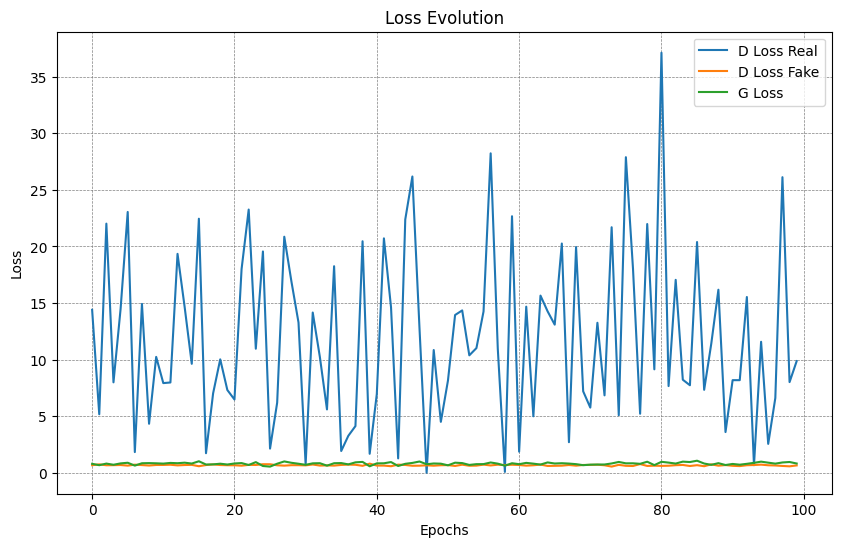

In [ ]:
    plt.figure(figsize=(10, 6))
    plt.plot(d_losses_real, label="D Loss Real")
    plt.plot(d_losses_fake, label="D Loss Fake")
    plt.plot(g_losses, label="G Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Evolution")
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
    plt.show()

Que bom que deu certo!

Quanto à interpretação do gráfico, aqui está o que você deve observar:

1. **D Loss Real**: Esta é a perda do discriminador quando ele tenta classificar os dados reais. Se esta perda aumentar muito, pode significar que o discriminador está tendo dificuldade em reconhecer os dados reais, o que não é ideal.

2. **D Loss Fake**: Esta é a perda do discriminador quando ele tenta classificar os dados gerados pelo gerador. Se esta perda for muito baixa, isso significa que o discriminador facilmente reconhece os dados falsos, o que também pode indicar que o gerador não está fazendo um bom trabalho. Se for muito alta, pode indicar que o gerador está enganando bem o discriminador.

3. **G Loss**: Esta é a perda do gerador. O gerador quer que esta perda seja baixa, pois isso indica que ele está enganando bem o discriminador. Se a perda do gerador for muito alta, isso pode significar que o discriminador está facilmente reconhecendo os dados falsos.

Agora, como você interpreta isso no contexto de uma GAN:

- **Estabilidade**: Em uma GAN bem treinada, as perdas se estabilizarão após certo ponto. Se você ver que as perdas continuam flutuando muito após várias épocas, isso pode indicar que a GAN não está convergindo.

- **Domínio**: Se a perda do discriminador for muito baixa e a perda do gerador for muito alta, isso pode indicar que o discriminador é muito forte e o gerador não consegue acompanhar. O oposto também pode ser verdadeiro: se o discriminador tiver uma perda muito alta e o gerador tiver uma perda muito baixa, isso pode indicar que o gerador é muito forte e o discriminador não pode acompanhar.

- **Modo de Colapso**: Se a "D Loss Fake" for muito baixa e a "G Loss" começar a aumentar rapidamente, pode ser um sinal de "modo de colapso", onde o gerador começa a produzir apenas um tipo de saída porque descobriu uma fraqueza específica no discriminador.

A ideia geral é que você quer um equilíbrio entre o gerador e o discriminador. Um não deve dominar o outro. Se isso acontecer, você pode precisar ajustar a arquitetura, o processo de treinamento ou a taxa de aprendizado.

Por último, lembre-se de que, embora a perda seja um bom indicador do desempenho de sua GAN, a prova final sempre será a saída gerada. Se você estiver satisfeito com a saída gerada, mesmo que as perdas não pareçam ideais, ainda pode ser uma GAN bem-sucedida.

###Gerando um outro coral

In [ ]:
def generate_chorale_gan(generator, seed_chords, length, latent_dim=100):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])

    for chord in range(length):
        noise = np.random.normal(0, 1, (1, latent_dim))
        generated_notes = generator.predict(noise)
        # Adapte a próxima linha conforme necessário para formatar a saída gerada
        generated_notes = np.round(generated_notes * 127).astype(int)  # converta para intervalo MIDI se a saída estiver entre 0 e 1
        arpegio = tf.concat([arpegio, tf.constant(generated_notes, dtype=tf.int64)], axis=1)

    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])


In [ ]:
generated_chords_gan = generate_chorale_gan(generator_trained, seed_chords, length=10)

1/1 [==============================] - 0s 20ms/step


In [ ]:
play_chords(generated_chords_gan, filepath=f"{MUSIC_FILES_PATH}/generated_chords_gan.wav")

Output hidden; open in https://colab.research.google.com to view.

### Comparações entre a criação e a música original

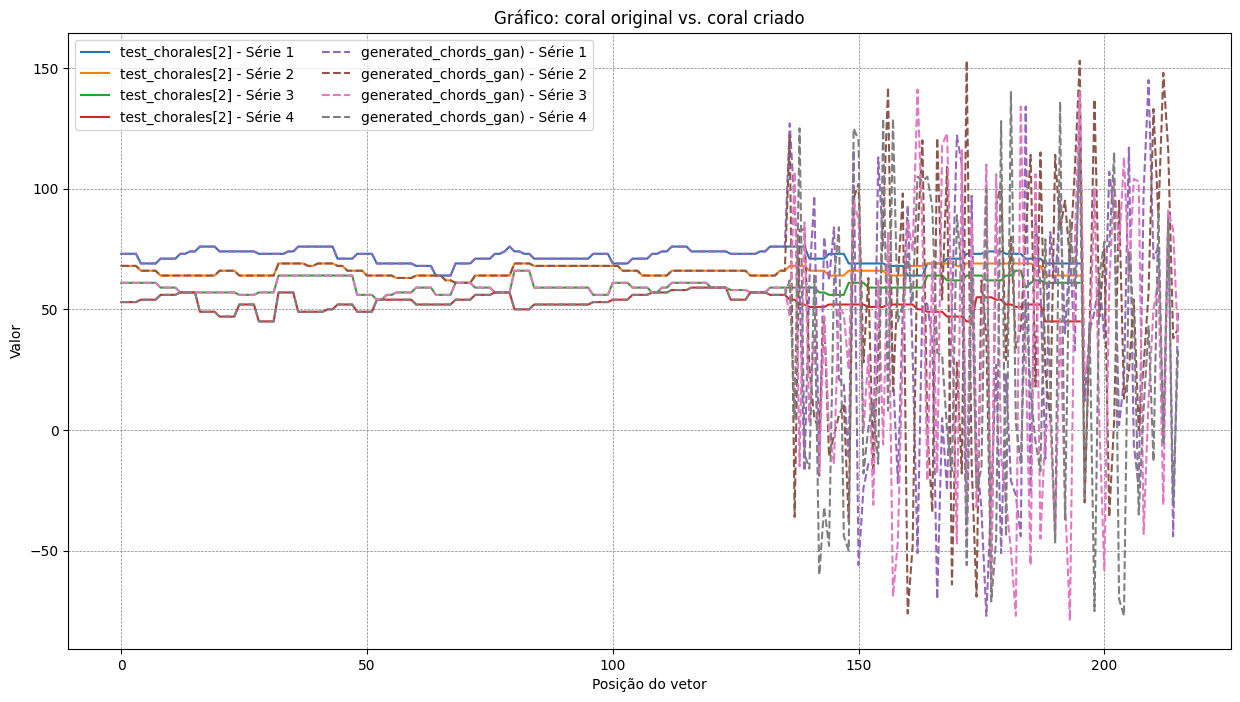

In [ ]:
plot_tensor_series(test_chorales[2], generated_chords_gan)

# Adicionando o parâmetro `temperature` na geração de novos corais

In [ ]:
def generate_chorale_v2(model, seed_chords, length, temperature=1, verbose=False):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))  # Pré-processa os acordes iniciais para obter o arpejo
    arpegio = tf.reshape(arpegio, [1, -1])  # Redimensiona o arpejo para ter formato [1, comprimento]
    for chord in range(length):  # Loop para gerar acordes adicionais
        for note in range(4):  # Loop para gerar cada nota do acorde
            next_note_probas = model.predict(arpegio, verbose=0)[0, -1:]  # Probabilidades previstas para a próxima nota
            rescaled_logits = tf.math.log(next_note_probas) / temperature  # Ajusta as probabilidades de acordo com a temperatura
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)  # Escolhe a próxima nota aleatoriamente de acordo com as probabilidades ajustadas
            arpegio = tf.concat([arpegio, next_note], axis=1)  # Concatena a próxima nota ao arpejo
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)  # Ajusta os valores do arpejo
    return tf.reshape(arpegio, shape=[-1, 4])  # Redimensiona o arpejo para ter formato de acordes


Neste código, a função `generate_chorale_v2` é uma versão modificada da função anterior que gera um coral com base em acordes iniciais usando o modelo treinado. As modificações introduzem a aleatoriedade nas escolhas das notas de acordo com as probabilidades previstas e a temperatura especificada.

* Os acordes iniciais são pré-processados e convertidos em arpejo usando a função `preprocess`.

* Em seguida, o arpejo é redimensionado para ter formato [1, comprimento].

* O código entra em um loop externo para gerar acordes adicionais.

* Dentro desse loop externo, há um loop interno que itera sobre cada nota do acorde.

* As probabilidades previstas para a próxima nota são obtidas usando `model.predict(arpegio)[0, -1:]`. Essas probabilidades são um vetor que representa a distribuição de probabilidade para cada possível nota.

* Os logitos (log-odds) são recalibrados usando a temperatura especificada. Isso é feito aplicando o logaritmo às probabilidades e dividindo pelo valor da temperatura. A temperatura controla a "ousadia" do sistema, pois afeta a dispersão das probabilidades.

* A próxima nota é escolhida aleatoriamente com base nas probabilidades recalibradas usando `tf.random.categorical`. O número de amostras é definido como 1, para escolher apenas uma nota.

* A próxima nota é concatenada ao arpejo usando `tf.concat`, expandindo o comprimento do arpejo.

* Após gerar todas as notas do acorde, o código ajusta os valores do arpejo usando `tf.where`, adicionando `min_note - 1` aos valores não nulos, para retornar as notas originais do coral.

* Por fim, o arpejo é redimensionado novamente para ter o formato de acordes [número_de_acordes, 4], onde cada acorde contém 4 notas.

Essa função gera um coral com base nos acordes iniciais fornecidos, usando o modelo treinado com a introdução da aleatoriedade nas escolhas das notas de acordo com as probabilidades previstas e a temperatura especificada.

# Criando chorais com diferentes nuaces sonoras

Vamos gerar 3 corais usando essa nova função: um frio, um médio e um quente.

Mude as sementes, comprimentos, temperaturas e veja os resultsos.

O código salva cada coral em um arquivo separado. Você pode executar essas células quantas vezes quiser!

## Coral original

In [ ]:
play_chords(test_chorales[2][:64], filepath=f"{MUSIC_FILES_PATH}/bach_test_4.wav")

Output hidden; open in https://colab.research.google.com to view.

### Nível conservador

In [ ]:
temp_conservador = 0.5

#### RNN - LSTM - v.01

In [ ]:
new_chorale_v2_cold_v01 = generate_chorale_v2(model_lstm_v01, seed_chords, COMPASS, temperature=temp_conservador, verbose=True)
play_chords(new_chorale_v2_cold_v01, filepath=f"{MUSIC_FILES_PATH}/bach_cold_lstm_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

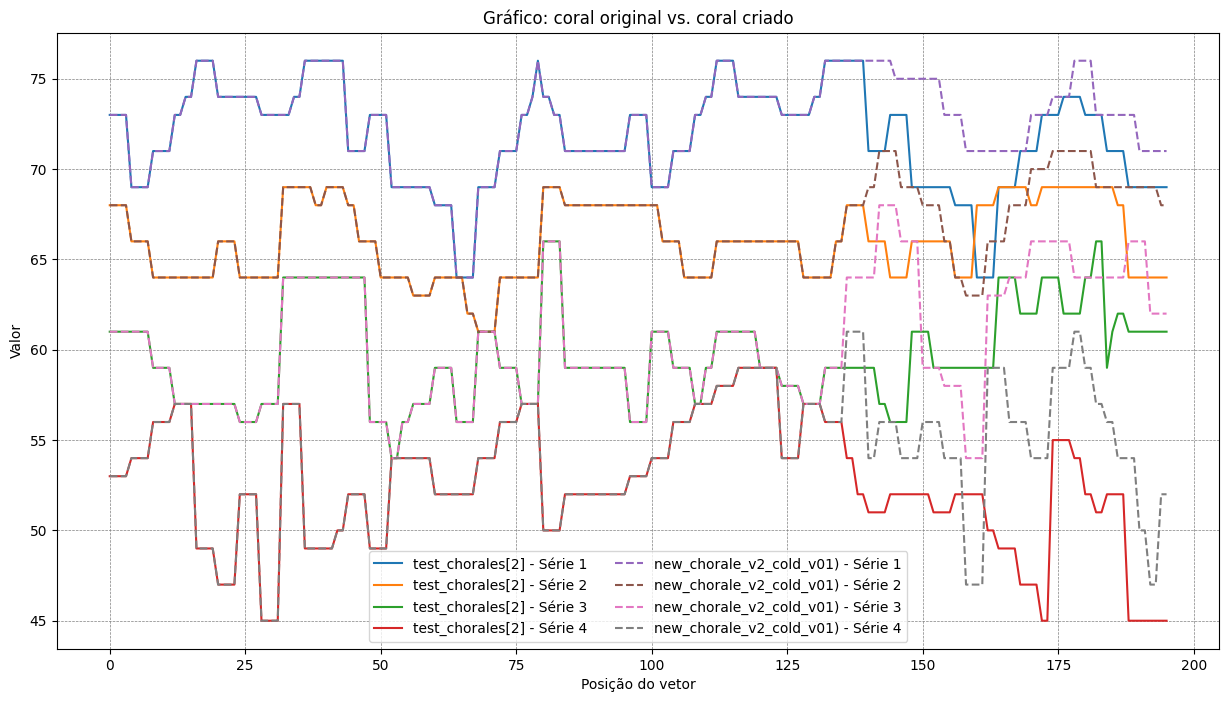

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_cold_v01)

#### RNN - LSTM - v.02

In [ ]:
new_chorale_v2_cold_v02 = generate_chorale_v2(model_lstm_v02, seed_chords, COMPASS, temperature=temp_conservador)
play_chords(new_chorale_v2_cold_v02, filepath=f"{MUSIC_FILES_PATH}/bach_cold_lstm_v02.wav")

Output hidden; open in https://colab.research.google.com to view.

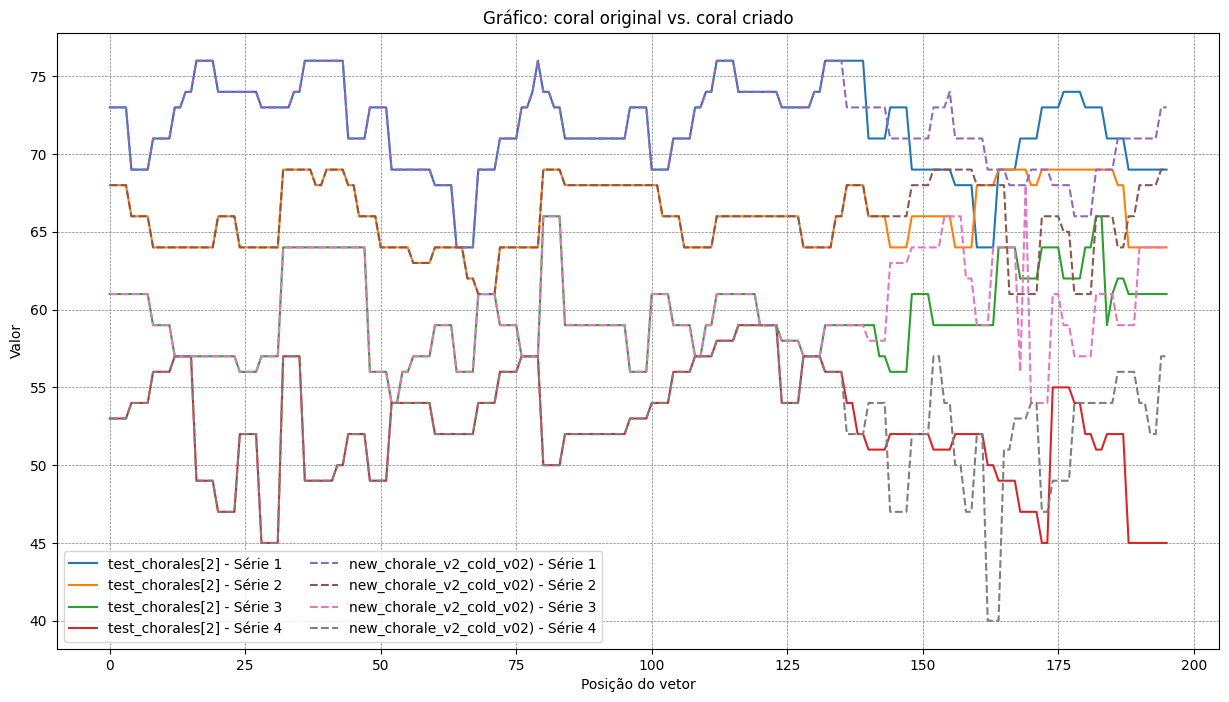

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_cold_v02)

#### RNN - LSTM - v.03

In [ ]:
new_chorale_v2_cold_v03 = generate_chorale_v2(model_lstm_v03, seed_chords, COMPASS, temperature=temp_conservador)
play_chords(new_chorale_v2_cold_v03, filepath=f"{MUSIC_FILES_PATH}/bach_cold_lstm_v03.wav")

Output hidden; open in https://colab.research.google.com to view.

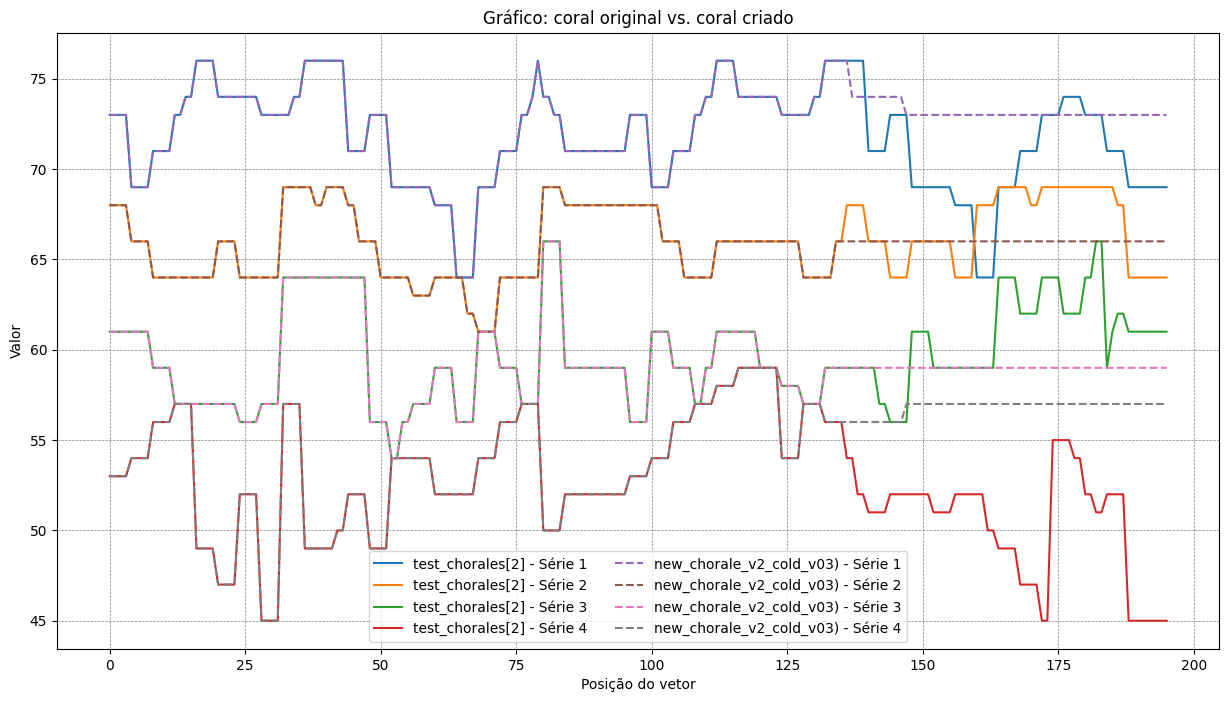

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_cold_v03)

#### RNN - LSTM - v.04

In [ ]:
new_chorale_v2_cold_v04 = generate_chorale_v2(model_lstm_v04, seed_chords, COMPASS, temperature=temp_conservador)
play_chords(new_chorale_v2_cold_v04, filepath=f"{MUSIC_FILES_PATH}/bach_cold_lstm_v04.wav")

Output hidden; open in https://colab.research.google.com to view.

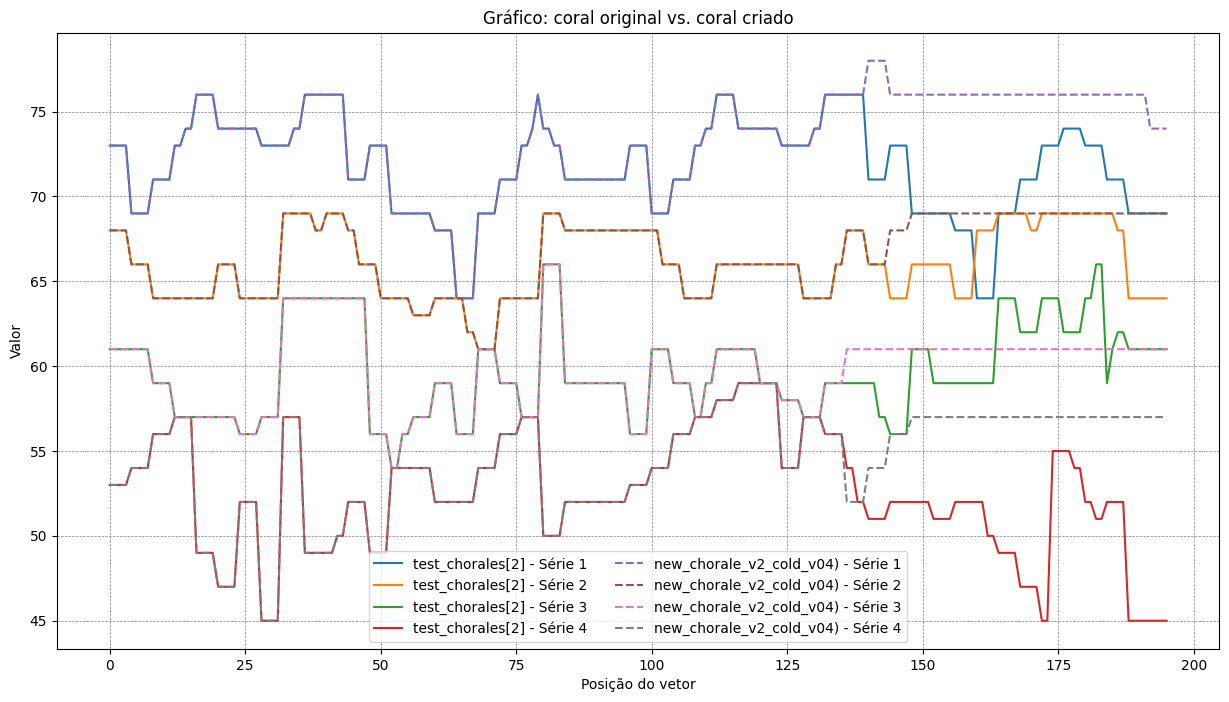

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_cold_v04)

#### RNN - GRU - v.01

In [ ]:
new_chorale_v2_cold_gru_v01 = generate_chorale_v2(model_gru_v01, seed_chords, COMPASS, temperature=temp_conservador)
play_chords(new_chorale_v2_cold_gru_v01, filepath=f"{MUSIC_FILES_PATH}/bach_cold_gru_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

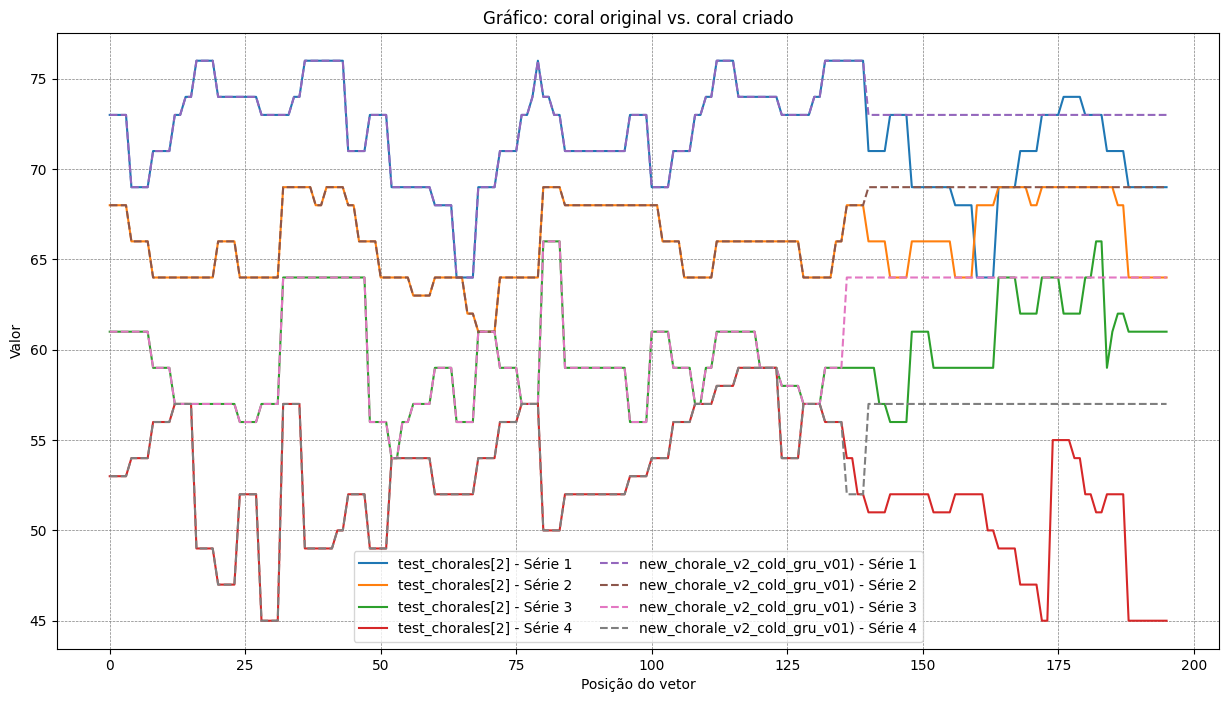

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_cold_gru_v01)

#### RNN - GRU - v.02

In [ ]:
new_chorale_v2_cold_gru_v02 = generate_chorale_v2(model_gru_v02, seed_chords, COMPASS, temperature=temp_conservador)
play_chords(new_chorale_v2_cold_gru_v02, filepath=f"{MUSIC_FILES_PATH}/bach_cold_gru_v02.wav")

Output hidden; open in https://colab.research.google.com to view.

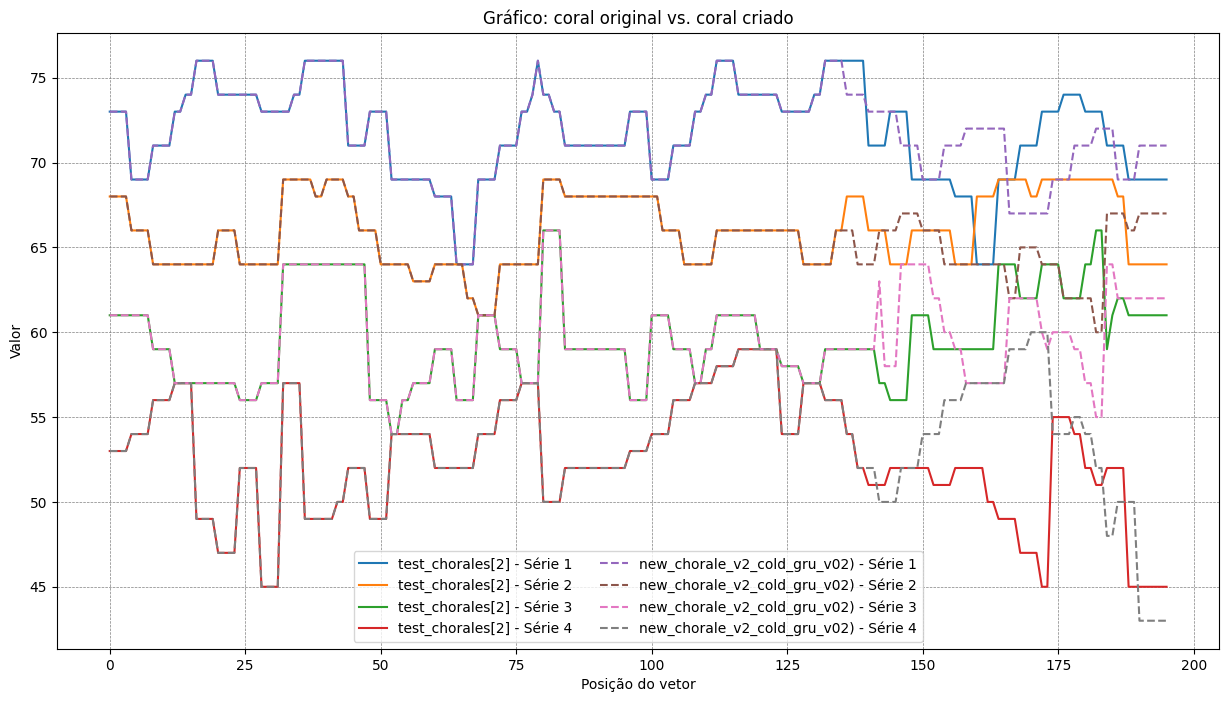

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_cold_gru_v02)

#### Transformer v.01

In [ ]:
new_chorale_v2_cold_t_v01 = generate_chorale_v2(model_t_v01, seed_chords, COMPASS, temperature=temp_conservador)
play_chords(new_chorale_v2_cold_t_v01, filepath=f"{MUSIC_FILES_PATH}/bach_cold_transf_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

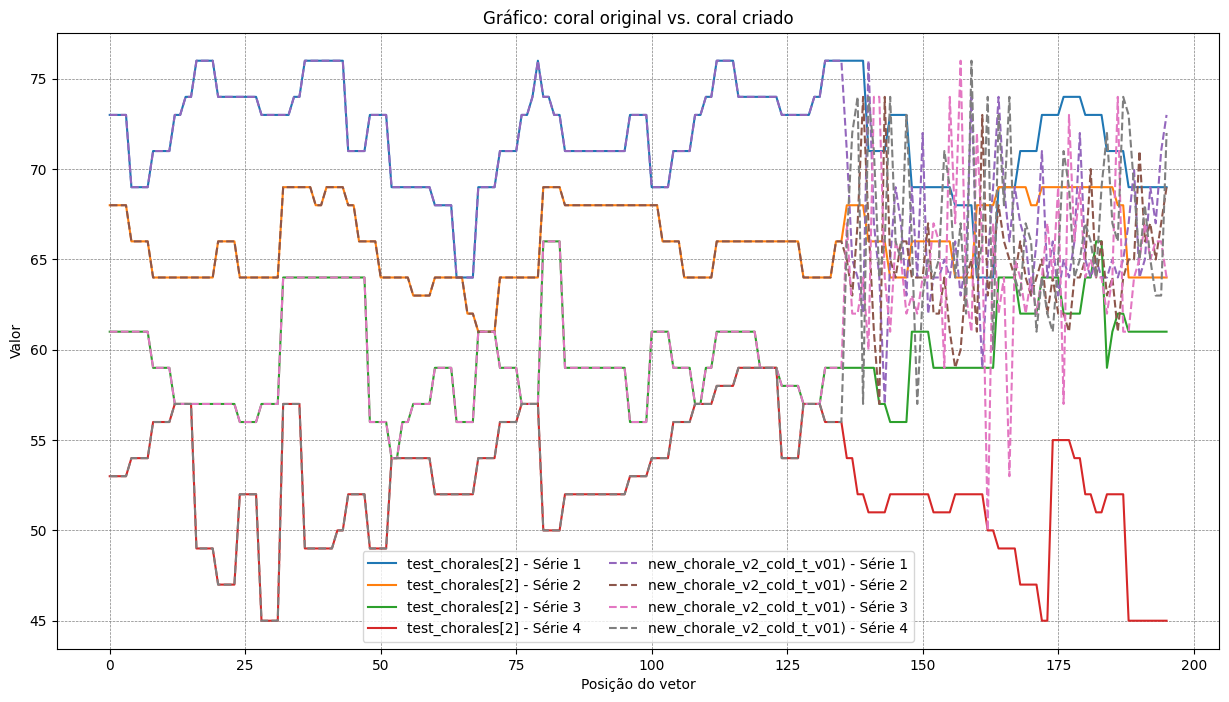

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_cold_t_v01)

### Nível moderado

In [ ]:
temp_moderado = 1

#### RNN - LSTM - v.01

In [ ]:
new_chorale_v2_cool_v01 = generate_chorale_v2(model_lstm_v01, seed_chords, COMPASS, temperature=temp_moderado)
play_chords(new_chorale_v2_cool_v01, filepath=f"{MUSIC_FILES_PATH}/bach_cool_lstm_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

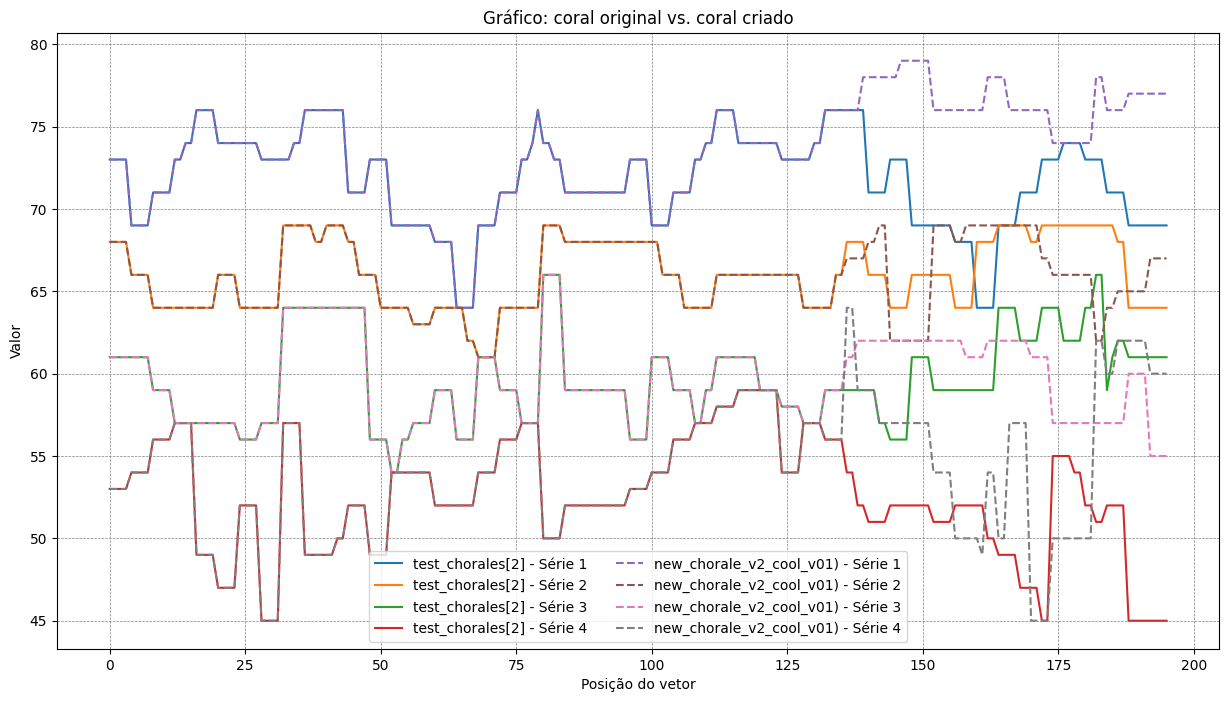

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_cool_v01)

#### RNN - LSTM - v.02

In [ ]:
new_chorale_v2_cool_v02 = generate_chorale_v2(model_lstm_v02, seed_chords, COMPASS, temperature=temp_moderado)
play_chords(new_chorale_v2_cool_v02, filepath=f"{MUSIC_FILES_PATH}/bach_cool_lstm_v02.wav")

Output hidden; open in https://colab.research.google.com to view.

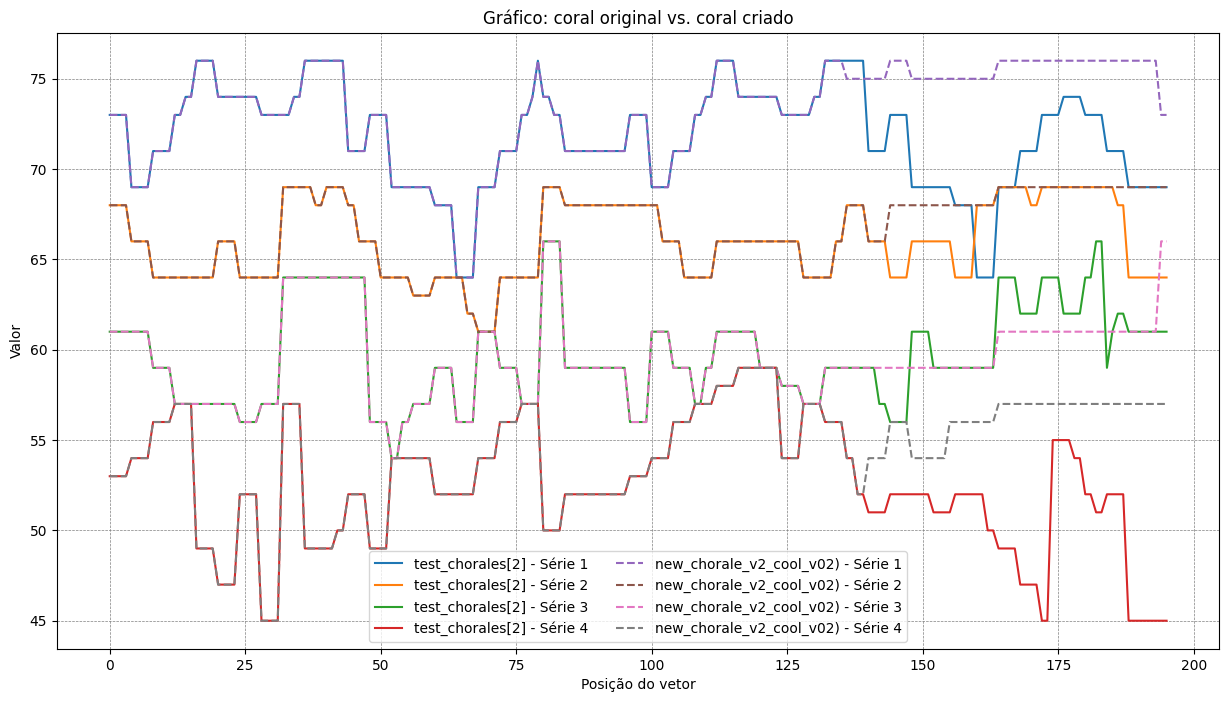

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_cool_v02)

#### RNN - LSTM - v.03

In [ ]:
new_chorale_v2_cool_v03 = generate_chorale_v2(model_lstm_v03, seed_chords, COMPASS, temperature=temp_moderado)
play_chords(new_chorale_v2_cool_v03, filepath=f"{MUSIC_FILES_PATH}/bach_cool_lstm_v03.wav")

Output hidden; open in https://colab.research.google.com to view.

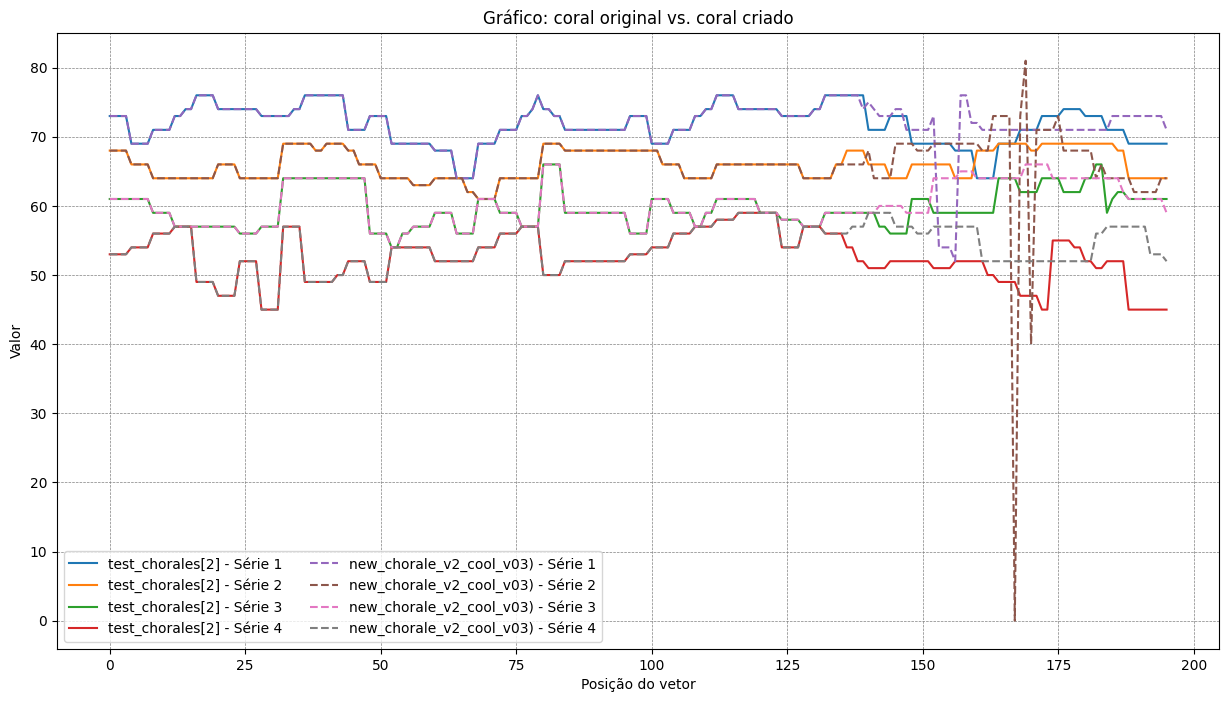

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_cool_v03)

#### RNN - LSTM - v.04

In [ ]:
new_chorale_v2_cool_v04 = generate_chorale_v2(model_lstm_v04, seed_chords, COMPASS, temperature=temp_moderado)
play_chords(new_chorale_v2_cool_v04, filepath=f"{MUSIC_FILES_PATH}/bach_cool_lstm_v04.wav")

Output hidden; open in https://colab.research.google.com to view.

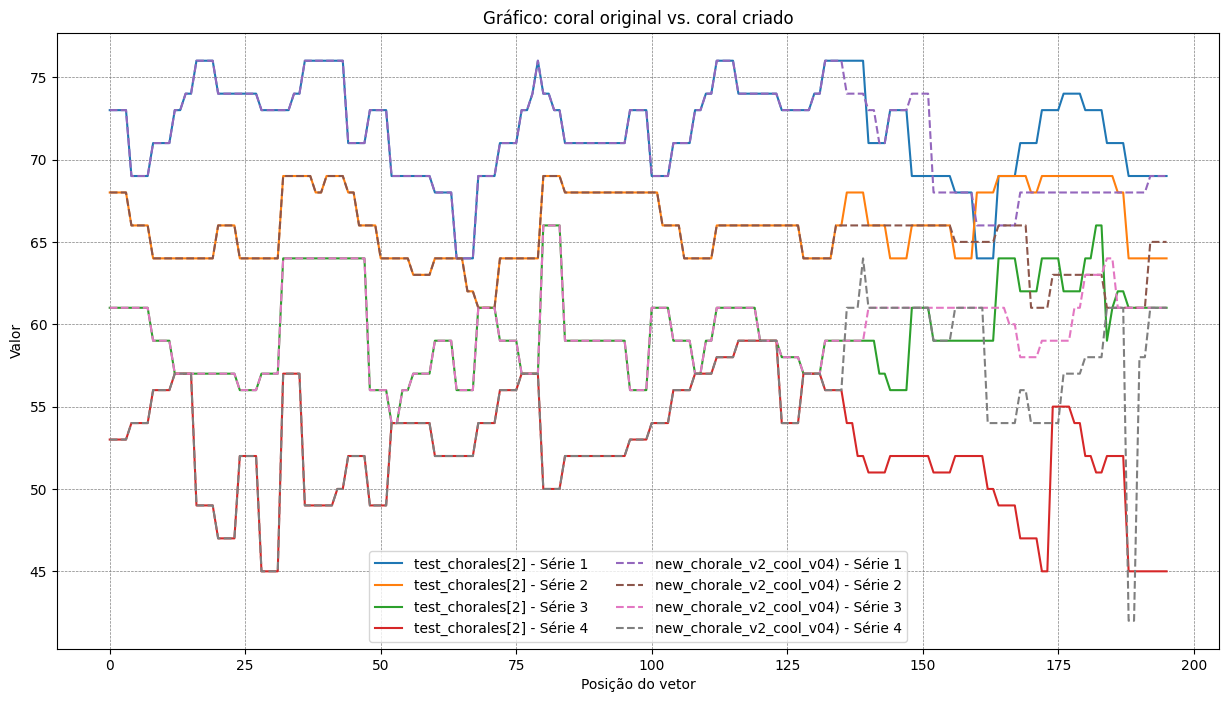

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_cool_v04)

#### RNN - GRU - v.01

In [ ]:
new_chorale_v2_cool_gru_v01 = generate_chorale_v2(model_gru_v01, seed_chords, COMPASS, temperature=temp_moderado)
play_chords(new_chorale_v2_cool_gru_v01, filepath=f"{MUSIC_FILES_PATH}/bach_cool_gru_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

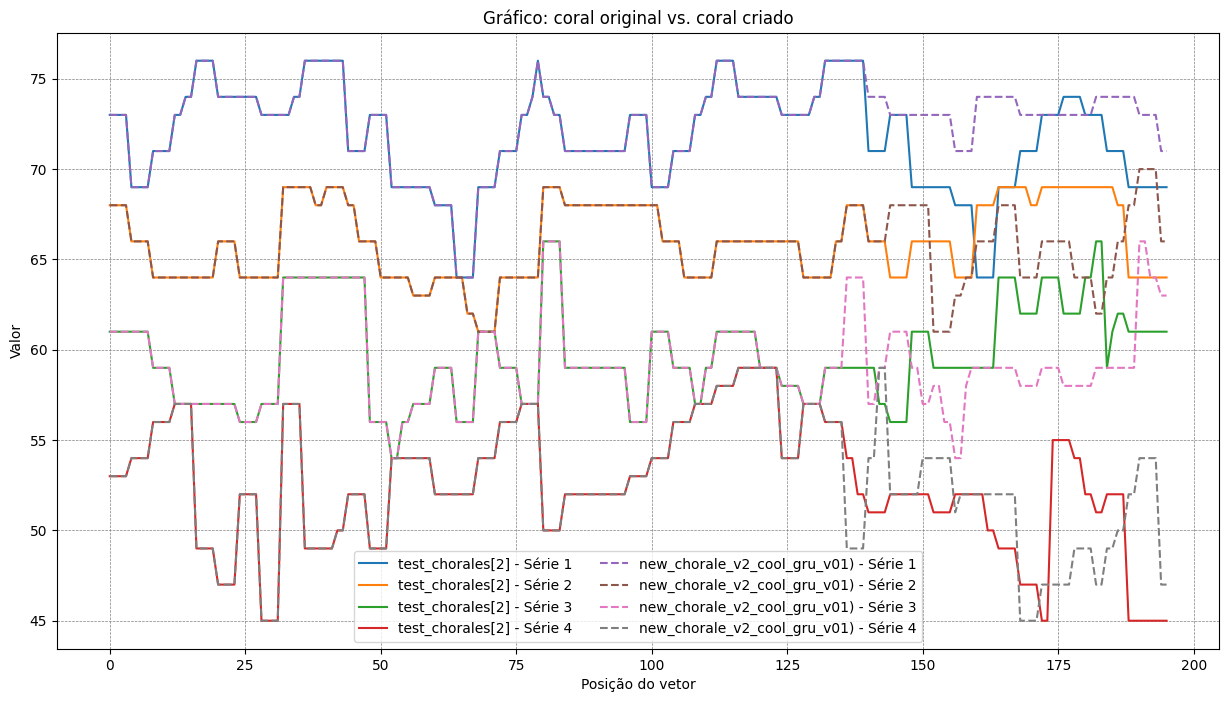

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_cool_gru_v01)

#### RNN - GRU - v.02

In [ ]:
new_chorale_v2_cool_gru_v02 = generate_chorale_v2(model_gru_v02, seed_chords, COMPASS, temperature=temp_moderado)
play_chords(new_chorale_v2_cool_gru_v02, filepath=f"{MUSIC_FILES_PATH}/bach_cool_gru_v02.wav")

Output hidden; open in https://colab.research.google.com to view.

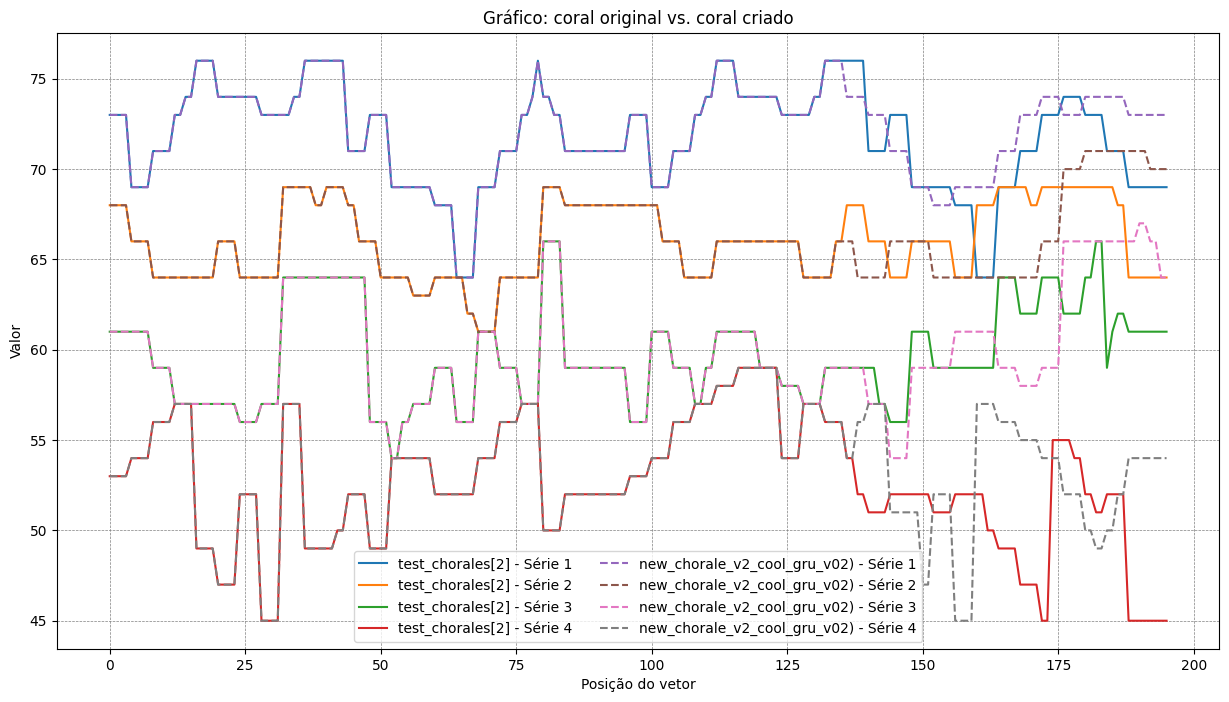

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_cool_gru_v02)

#### Transformer v.01

In [ ]:
new_chorale_v2_cool_t_v01 = generate_chorale_v2(model_t_v01, seed_chords, COMPASS, temperature=temp_moderado)
play_chords(new_chorale_v2_cool_t_v01, filepath=f"{MUSIC_FILES_PATH}/bach_cool_transf_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

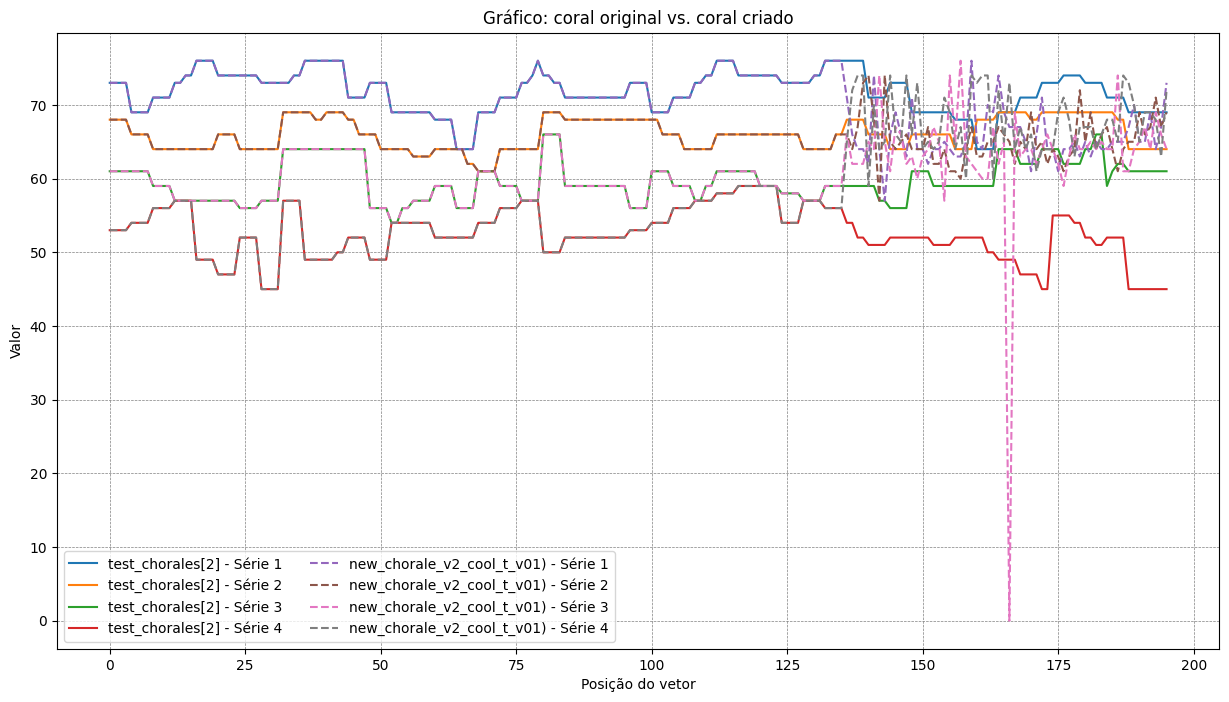

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_cool_t_v01)

### Nível hardcore

In [ ]:
temp_hardcore = 1.7

#### RNN - LSTM - v.01

In [ ]:
new_chorale_v2_hot_v01 = generate_chorale_v2(model_lstm_v01, seed_chords, COMPASS, temperature=temp_hardcore)
play_chords(new_chorale_v2_hot_v01, filepath=f"{MUSIC_FILES_PATH}/bach_hot_lstm_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

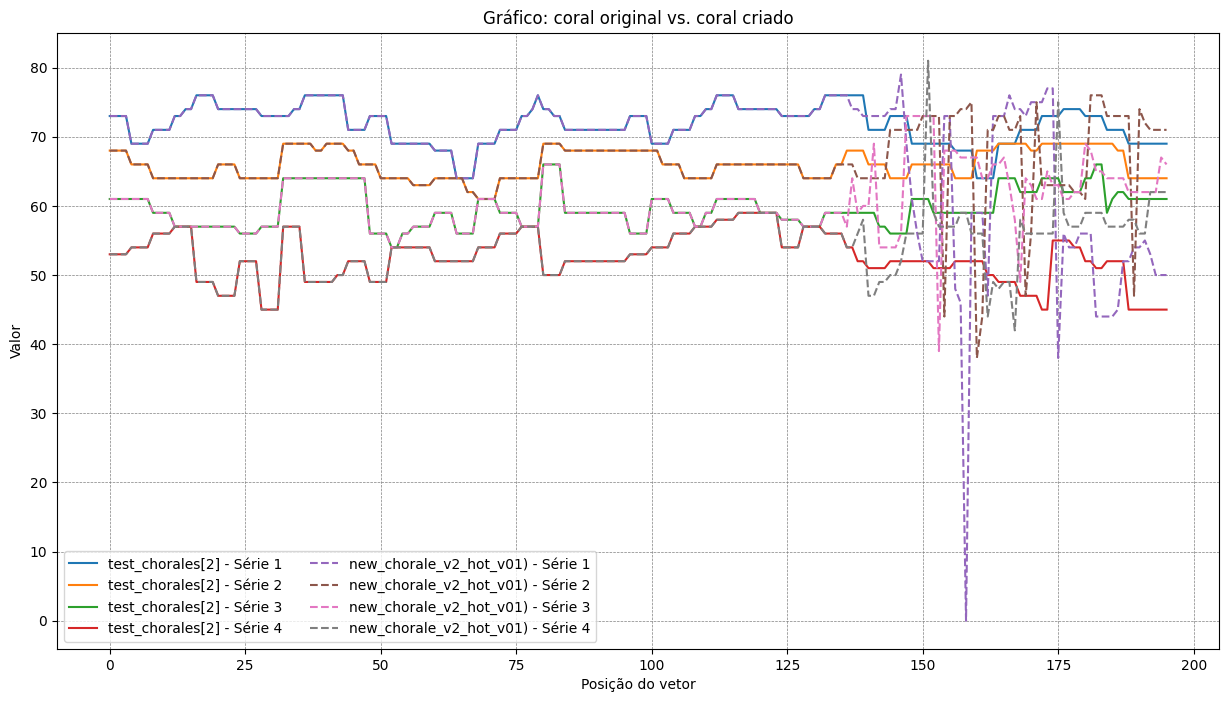

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_hot_v01)

#### RNN - LSTM - v.02

In [ ]:
new_chorale_v2_hot_v02 = generate_chorale_v2(model_lstm_v02, seed_chords, COMPASS, temperature=temp_hardcore)
play_chords(new_chorale_v2_hot_v02, filepath=f"{MUSIC_FILES_PATH}/bach_hot_lstm_v02.wav")

Output hidden; open in https://colab.research.google.com to view.

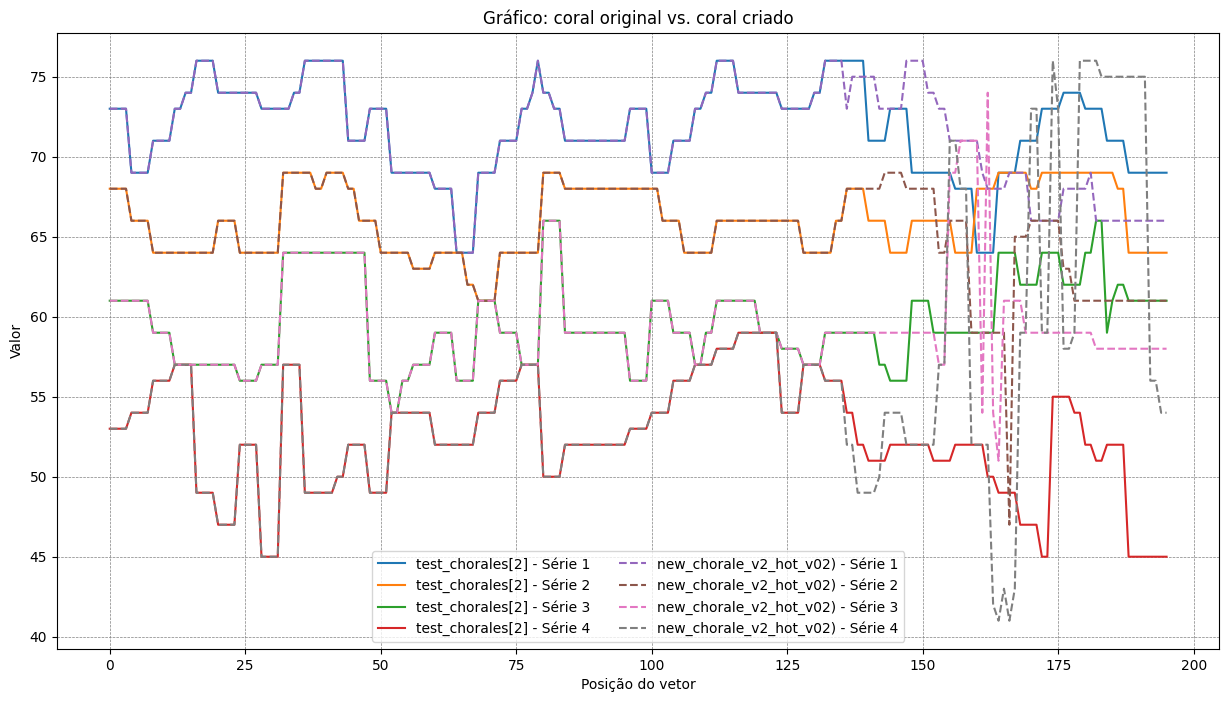

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_hot_v02)

#### RNN - LSTM - v.03

In [ ]:
new_chorale_v2_hot_v03 = generate_chorale_v2(model_lstm_v03, seed_chords, COMPASS, temperature=temp_hardcore)
play_chords(new_chorale_v2_hot_v03, filepath=f"{MUSIC_FILES_PATH}/bach_hot_lstm_v03.wav")

Output hidden; open in https://colab.research.google.com to view.

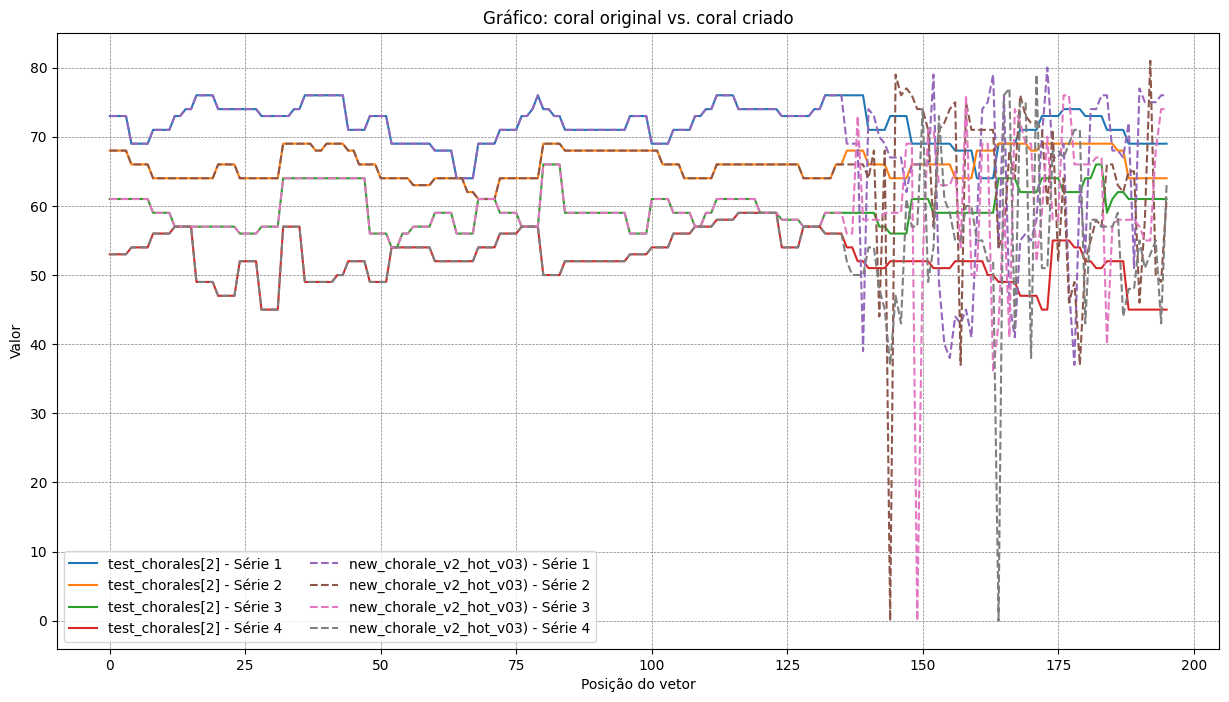

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_hot_v03)

#### RNN - LSTM - v.04

In [ ]:
new_chorale_v2_hot_v04 = generate_chorale_v2(model_lstm_v04, seed_chords, COMPASS, temperature=temp_hardcore)
play_chords(new_chorale_v2_hot_v04, filepath=f"{MUSIC_FILES_PATH}/bach_hot_lstm_v04.wav")

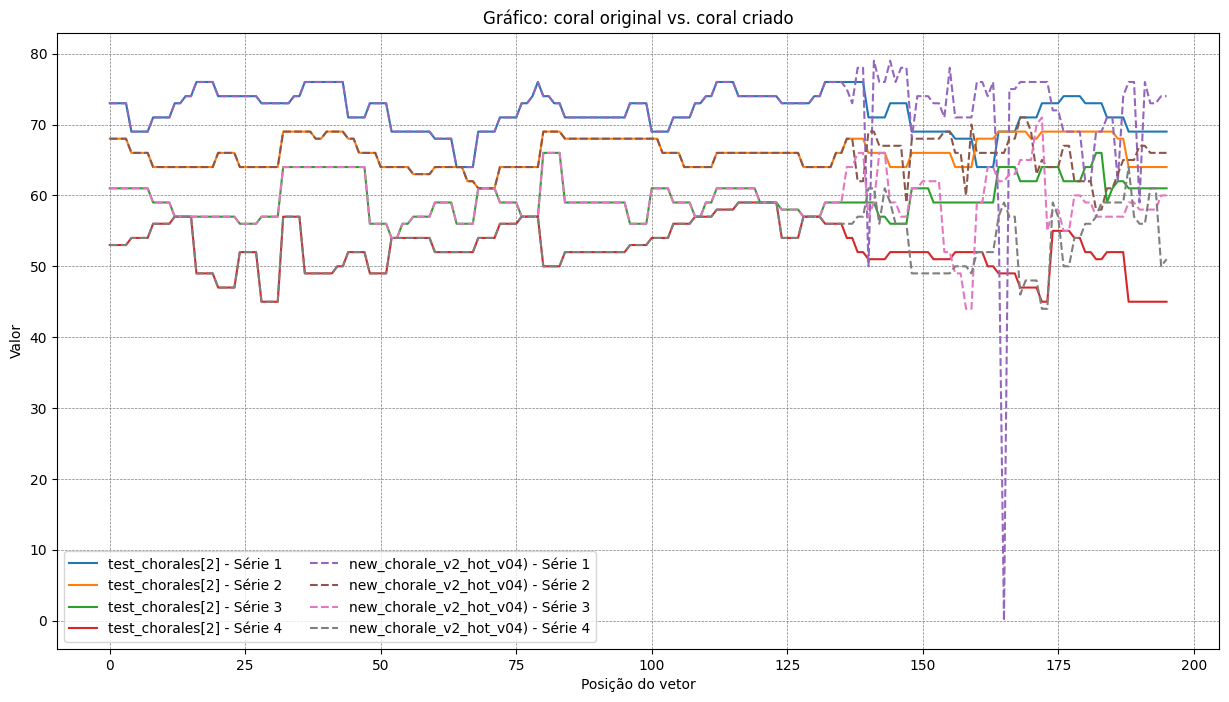

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_hot_v04)

#### RNN - GRU - v.01

In [ ]:
new_chorale_v2_hot_gru_v01 = generate_chorale_v2(model_gru_v01, seed_chords, COMPASS, temperature=temp_hardcore)
play_chords(new_chorale_v2_hot_gru_v01, filepath=f"{MUSIC_FILES_PATH}/bach_hot_gru_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

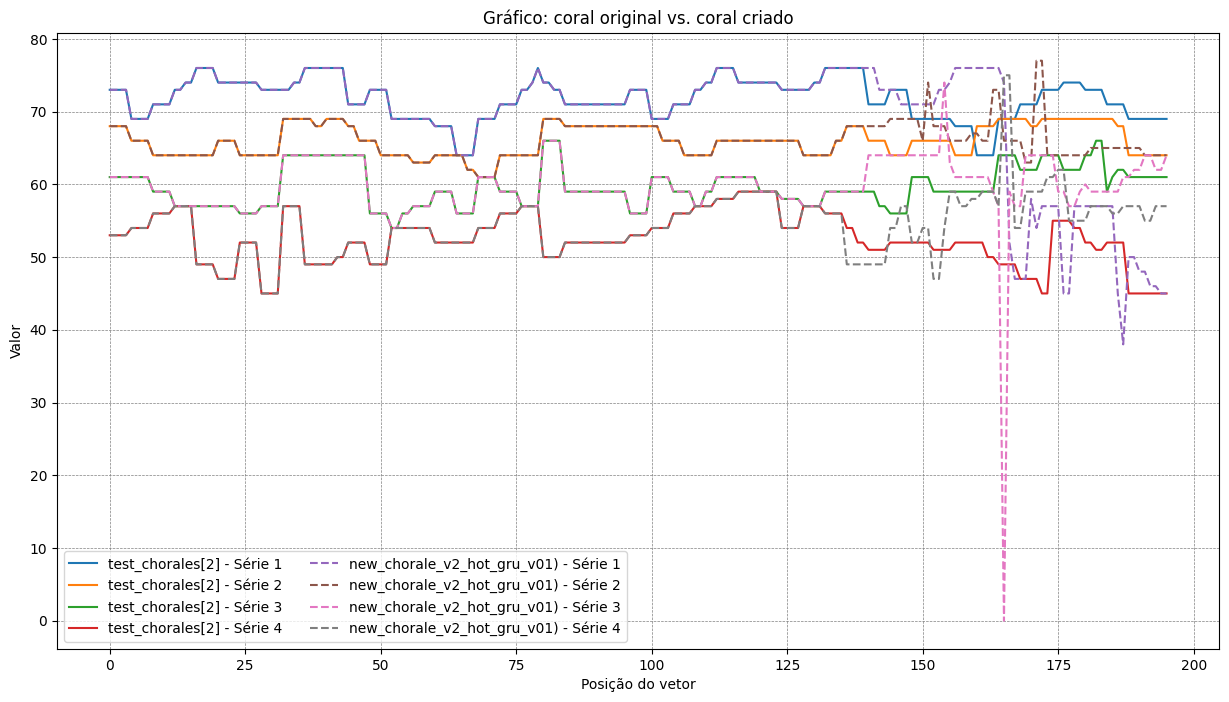

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_hot_gru_v01)

#### RNN - GRU - v.02

In [ ]:
new_chorale_v2_hot_gru_v02 = generate_chorale_v2(model_gru_v02, seed_chords, COMPASS, temperature=temp_hardcore)
play_chords(new_chorale_v2_hot_gru_v02, filepath=f"{MUSIC_FILES_PATH}/bach_hot_gru_v02.wav")

Output hidden; open in https://colab.research.google.com to view.

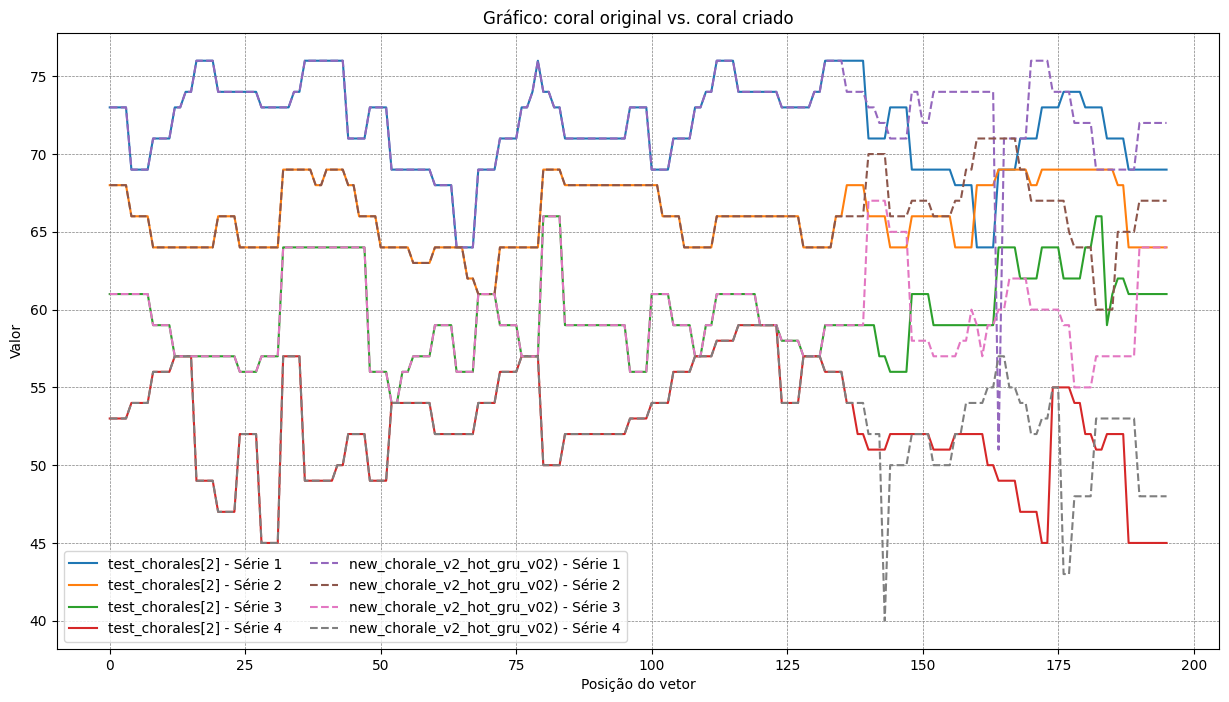

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_hot_gru_v02)

#### Transformer v.01

In [ ]:
new_chorale_v2_hot_t_v01 = generate_chorale_v2(model_t_v01, seed_chords, COMPASS, temperature=temp_hardcore)
play_chords(new_chorale_v2_hot_t_v01, filepath=f"{MUSIC_FILES_PATH}/bach_hot_t_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

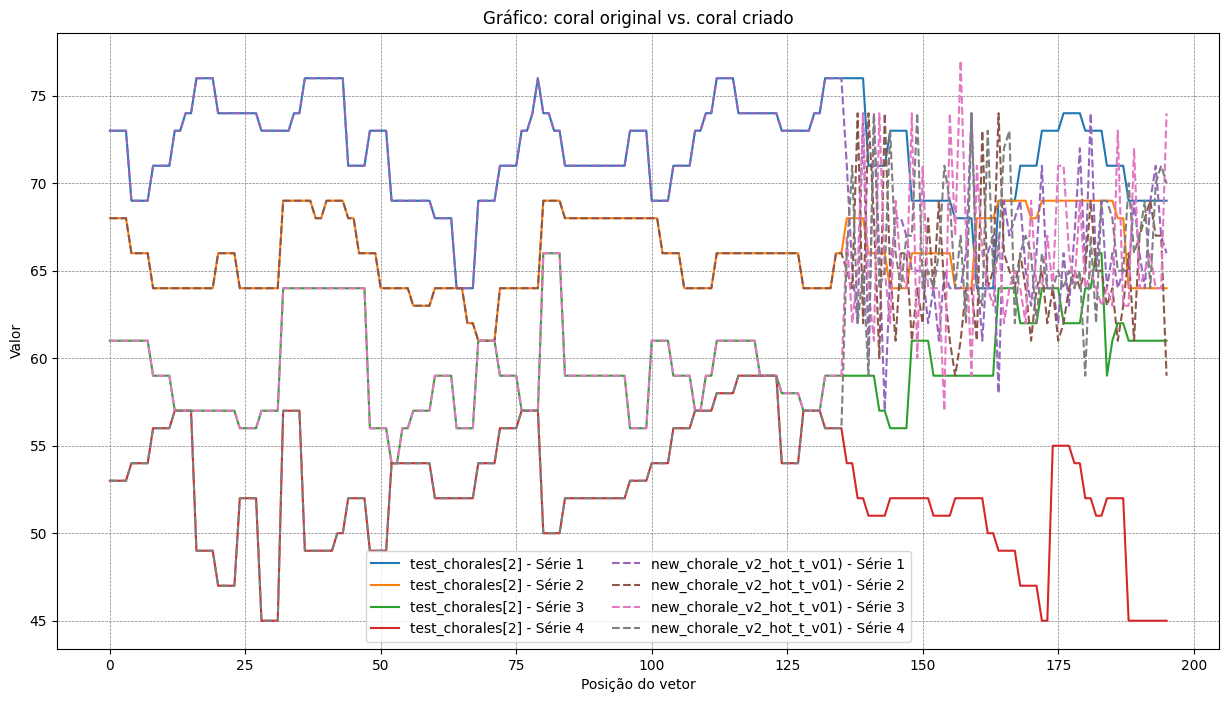

In [ ]:
plot_tensor_series(test_chorales[2], new_chorale_v2_hot_t_v01)

#Referências

 * [Music Generation with Deep Learning;](https://arxiv.org/abs/1612.04928)
 * [Music Generation by Deep Learning - Challenges and Directions;](https://arxiv.org/abs/1712.04371)
 * [Deep Learning Techniques for Music Generation -- A Survey;](https://arxiv.org/abs/1709.01620)
 * [Deep learning for music generation: challenges and directions;](https://link.springer.com/article/10.1007/s00521-018-3813-6)
 * [Generating Music Using Deep Learning;](https://towardsdatascience.com/generating-music-using-deep-learning-cb5843a9d55e)
 * [Geração de Músicas Utilizando Redes Adversárias Generativas;](http://www.uel.br/cce/dc/wp-content/uploads/ProjetoTCC_Vitor_de_Castro_Silva.pdf)